## Introducción: Modelado de Series Temporales con Transformers

### Índice

- [SAITS (Self-Attention-based Imputation for Time Series)](https://nbviewer.org/github/marsgr6/rna-online/blob/main/saits_transformers_ts.ipynb#saits)
- [Transformers para predecir valores futuros](https://nbviewer.org/github/marsgr6/rna-online/blob/main/saits_transformers_ts.ipynb#transformers)


## Series temporales

Una **serie temporal** es una secuencia de observaciones recogidas en intervalos regulares de tiempo. A diferencia de otros tipos de datos, en una serie temporal el orden es fundamental, ya que los valores pasados influyen, a veces de forma compleja, en los valores futuros.

### ¿Por qué modelar series temporales?

El modelado de series temporales permite:

* **Predecir comportamientos futuros**, como la demanda de energía o los precios del mercado.
* **Detectar anomalías**, por ejemplo en sensores industriales o fraudes financieros.
* **Simular escenarios** en sistemas complejos como el clima o el tráfico.
* **Entender patrones** como estacionalidad, ciclos o tendencias estructurales.

Estas capacidades son fundamentales en sectores como:

* **Finanzas**: predicción de precios, riesgos y volatilidad.
* **Salud**: monitoreo de signos vitales, evolución de enfermedades.
* **Retail y supply chain**: pronóstico de demanda, optimización de inventarios.
* **IoT y smart cities**: análisis de sensores, mantenimiento predictivo.
* **Ciencias ambientales**: predicción climática, monitoreo de contaminación.

### Evolución de los métodos para series temporales

| Enfoque                                                            | Características principales                                           | Limitaciones                                                          |
| ------------------------------------------------------------------ | --------------------------------------------------------------------- | --------------------------------------------------------------------- |
| **Modelos estadísticos**<br>(ARIMA, SARIMA, Exponential Smoothing) | Interpretables, requieren supuestos sobre estacionalidad y linealidad | No capturan bien relaciones no lineales ni dependencias a largo plazo |
| **Modelos clásicos de ML**<br>(Random Forest, XGBoost)             | Pueden capturar no linealidades con ingeniería de features            | No aprovechan la secuencialidad de los datos explícitamente           |
| **Redes recurrentes (RNN, LSTM, GRU)**                             | Modelan dependencias temporales, manejo secuencial de datos           | Dificultad con secuencias largas, entrenamiento costoso               |
| **Transformers**                                                   | Atención directa a toda la secuencia, paralelización eficiente        | Requieren más datos y recursos computacionales                        |


### ¿Por qué Transformers?

Los **Transformers** revolucionaron el modelado secuencial en NLP, pero su capacidad de atención permite también capturar **relaciones a largo plazo** en series temporales, sin necesidad de procesar secuencialmente paso a paso como en las RNN. Algunas de sus ventajas clave son:

* **Captura de dependencias globales** mediante *self-attention*.
* **Paralelización eficiente** durante el entrenamiento.
* **Flexibilidad arquitectónica**: pueden adaptarse a datos multivariados, series irregulares o múltiples horizontes de predicción.

**En este notebook exploraremos:**

¡Gracias por la aclaración! Aquí tienes la lista corregida y completa, con redacción clara y consistente:


1. **La naturaleza y preparación de los datos de series temporales.**
   Se aborda cómo caracterizar, limpiar y transformar series temporales multivariadas para su uso en modelos de imputación y predicción.

2. **El uso de SAITS (Self-Attention-based Imputation for Time Series).**
   Se explora cómo emplear el modelo SAITS para imputar valores faltantes en series temporales, aprovechando mecanismos de atención para capturar relaciones complejas entre variables y momentos en el tiempo.

3. **El uso de una arquitectura basada en Transformers para predecir valores futuros.**
   Se implementa y entrena un Transformer adaptado para series temporales, analizando su capacidad para modelar dependencias de largo plazo y su ventaja frente a modelos tradicionales.

4. **Métricas de evaluación y comparación con modelos tradicionales.**
   Se utilizan métricas como RMSE y R² para evaluar la calidad de la imputación y de la predicción, discutiendo los resultados en comparación con métodos clásicos (por ejemplo, interpolación, MLP, LSTM).

Esta experiencia busca desarrollar una comprensión aplicada de cómo aprovechar la potencia de los Transformers en problemas reales de series temporales, y cómo superar las limitaciones de los enfoques tradicionales.

In [ ]:
!pip install pypots==0.11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.5/597.5 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: pypots
    Found existing installation: pypots 0.12
    Uninstalling pypots-0.12:
      Successfully uninstalled pypots-0.12


In [ ]:
import missingno as msno
import pandas as pd
import numpy as np
from pypots.imputation import SAITS

/usr/local/lib/python3.11/dist-packages/pypots/nn/functional/cuda.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return autocast(**kwargs)



████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 



In [ ]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/marsgr6/r-scripts/refs/heads/master/data/dataset2_cuenca.csv')
df

FECHA   QH0889  QH0894  PRECIPITACION M0141  PRECIPITACION M0501  \
0    1980-01   54.521  15.784                119.3                245.5   
1    1980-02   54.666  30.408                120.2                 31.4   
2    1980-03  120.460  37.035                128.8                161.2   
3    1980-04  110.465  85.364                156.6                224.3   
4    1980-05   92.278  46.099                 75.3                 82.8   
..       ...      ...     ...                  ...                  ...   
463  2018-08   61.781  41.290                  NaN                  NaN   
464  2018-09   61.781  41.290                  NaN                  NaN   
465  2018-10   61.781  41.290                  NaN                  NaN   
466  2018-11   61.781  41.290                  NaN                  NaN   
467  2018-12   61.781  41.290                  NaN                  NaN   

     PRECIPITACION M0431    SST  SPI M0141  SPI M0501  SPI M0431  
0                    NaN  27.16       0.37       0.88        NaN  
1                    NaN  27.57       0.39      -1.51        NaN  
2                    NaN  27.85       0.57      -0.06        NaN  
3                    NaN  28.18       1.16       0.65        NaN  
4                    NaN  28.17      -0.56      -0.93        NaN  
..                   ...    ...        ...        ...        ...  
463                  NaN  27.53        NaN        NaN        NaN  
464                  NaN  27.61        NaN        NaN        NaN  
465                  NaN  27.73        NaN        NaN        NaN  
466                  NaN  27.83        NaN        NaN        NaN  
467                  NaN  27.86        NaN        NaN        NaN  

[468 rows x 10 columns]

La imagen a continuación muestra un **diagrama de valores faltantes** generado comúnmente con bibliotecas como `missingno` en Python. Este tipo de visualización es muy útil para entender la **estructura y patrón de los datos ausentes** en un conjunto multivariado de series temporales.

### 📊 Interpretación de la matriz de valores faltantes

Cada fila representa una **instancia temporal** (por ejemplo, una fecha específica), y cada columna representa una **variable** (como una estación meteorológica o un índice climático).

* **Color negro**: datos presentes.
* **Color blanco**: valores faltantes.
* La línea del costado derecho indica la **frecuencia acumulada de valores faltantes por observación**.


### 🔍 Observaciones clave

1. **Variables completas**:

   * Las columnas `FECHA`, `QH0889` y `SST` no presentan valores faltantes (100% negro), lo cual es positivo, especialmente `FECHA`, que suele usarse como índice temporal.

2. **Variables parcialmente incompletas**:

   * Variables como `QH0894`, `PRECIPITACION M0141`, `SPI M0501`, etc., presentan **bloques de datos faltantes**, algunos de forma intermitente.
   * La presencia de bloques sugiere que hubo **periodos enteros sin datos**, probablemente por fallas en sensores o vacíos en los registros.

3. **Patrones comunes**:

   * Algunas variables comparten el mismo patrón de faltantes (ej. `SPI M0141` y `SPI M0431`), lo cual indica posibles relaciones o dependencias estructurales en la forma en que se recolectan.

4. **Distribución en el tiempo**:

   * En la parte inferior del gráfico, se observa un **aumento en la proporción de valores faltantes por observación** (línea de la derecha asciende). Esto podría indicar que las observaciones más recientes (o más antiguas) tienen más datos perdidos, algo común en bases de datos históricas.


### ⚠️ Implicaciones para el modelado

* La imputación será **necesaria** antes de aplicar modelos predictivos.
* La cantidad y el patrón de los faltantes **afectarán la elección del método de imputación**.

  * Métodos simples como media/interpolación **no capturan relaciones cruzadas entre variables**.
  * Métodos avanzados como **SAITS** o **BRITS** pueden aprender del contexto temporal y multivariable.


### ✅ Próximo paso

Usaremos **SAITS** para imputar estos valores faltantes de forma eficiente y robusta, preservando la estructura temporal y las correlaciones entre variables.

<Axes: >

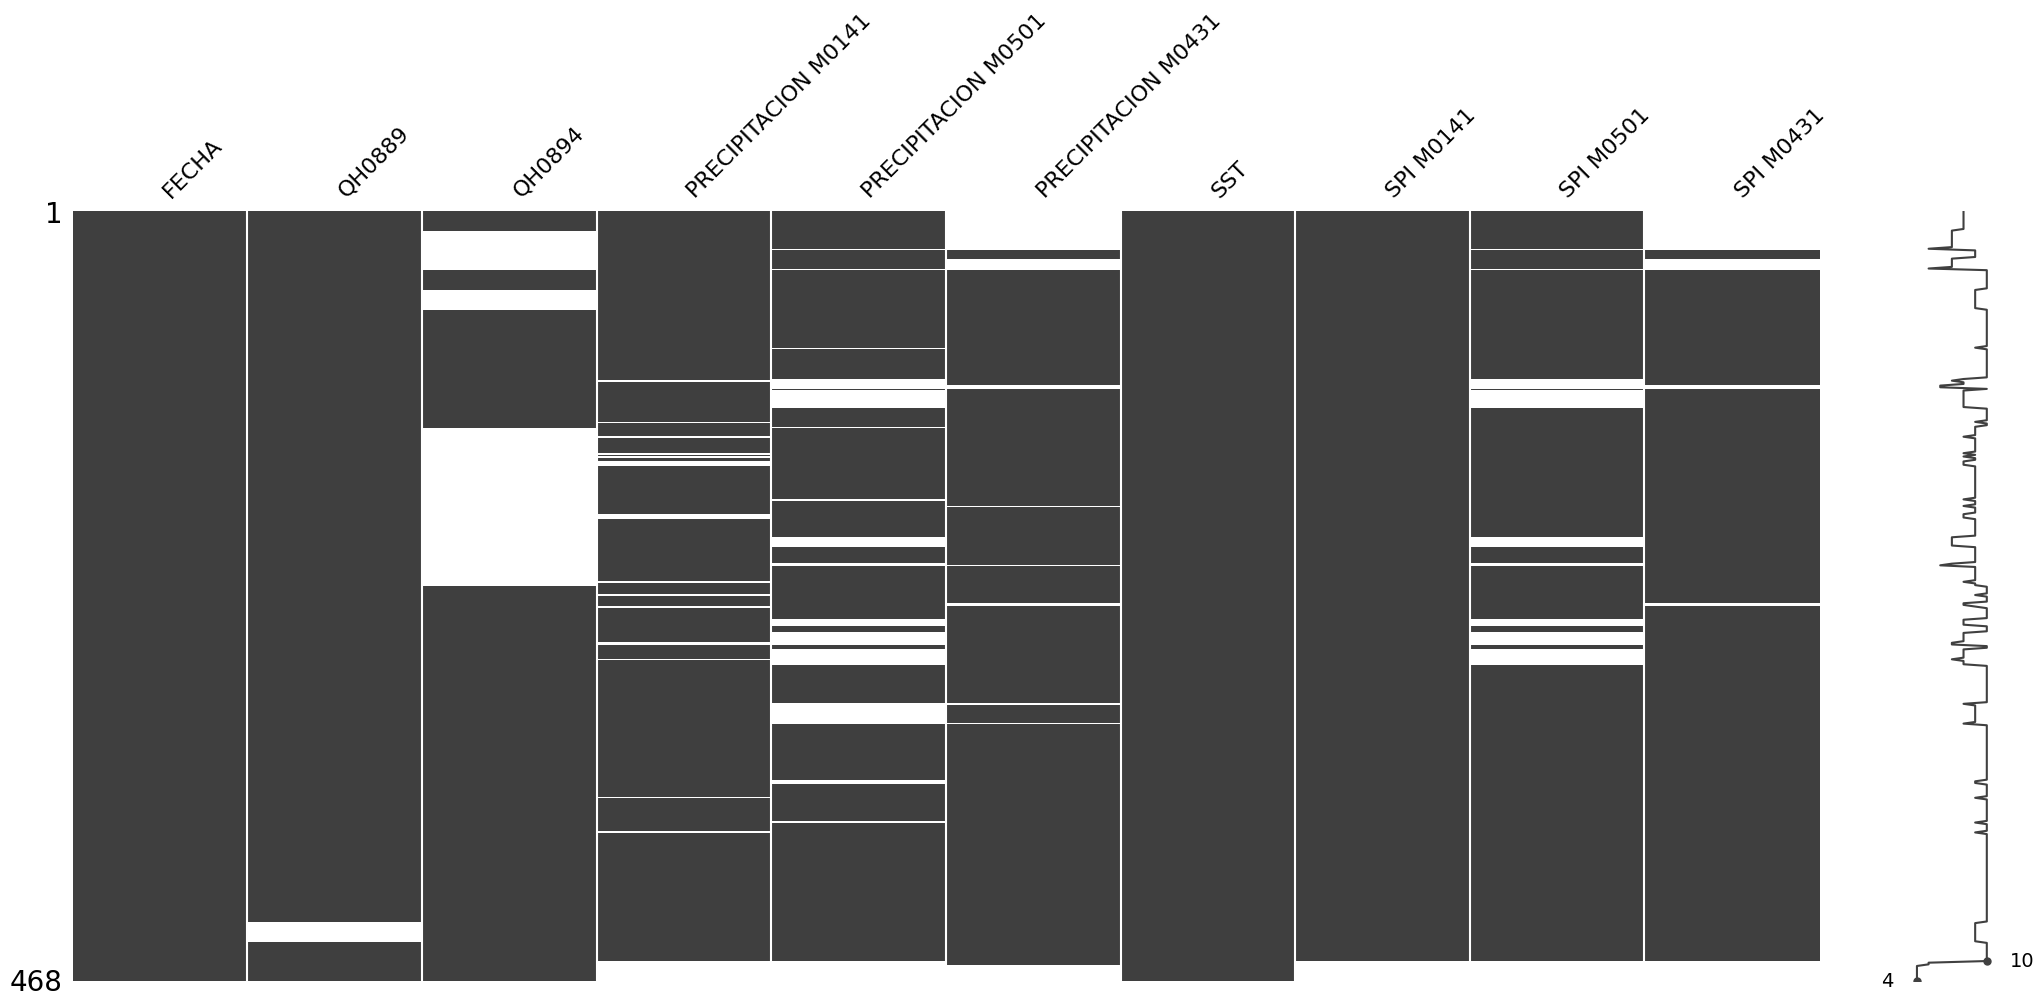

In [ ]:
msno.matrix(df)

## Imputación de Series Temporales con SAITS

Antes de aplicar modelos de predicción, es crucial **imputar valores faltantes** en series temporales, ya que muchos algoritmos requieren entradas completas para funcionar correctamente. En este notebook, comenzaremos utilizando el modelo **SAITS** (*Self-Attention-based Imputation for Time Series*), una arquitectura basada en Transformers específicamente diseñada para imputación multivariada de series temporales.

### ¿Qué es SAITS?

**SAITS** es una arquitectura de red neuronal profunda que utiliza mecanismos de **auto-atención (self-attention)** para aprender patrones temporales y de dependencia cruzada entre variables. Fue propuesta para abordar los desafíos comunes de imputación en series temporales:

* Faltantes no uniformes en múltiples variables.
* Estructuras temporales complejas y no lineales.
* Necesidad de imputaciones *context-aware* (dependientes de contexto).

### Arquitectura de SAITS

SAITS consta de tres bloques principales:

1. ### **Codificador con atención bidireccional**

   * Utiliza *multi-head self-attention* para capturar dependencias tanto **temporales** como **entre variables**.
   * Procesa las secuencias incompletas junto con un *masking vector* que indica qué valores están ausentes.
   * Genera una representación latente de la serie.

2. ### **Decodificador de imputación**

   * Dos capas de *self-attention* que refinan la representación latente generada por el codificador.
   * Predice valores faltantes en todas las posiciones (no solo en puntos específicos).

3. ### **Reconstrucción**

   * La red es entrenada con una técnica de *masked modeling*: oculta valores que sí existen y entrena al modelo para reconstruirlos, simulando faltantes.
   * La función de pérdida es el **Mean Squared Error (MSE)** entre los valores reales y los imputados en posiciones ocultas.

### Ventajas de SAITS

* ✅ Capta **relaciones de largo plazo** sin necesidad de suponer linealidad.
* ✅ Admite **faltantes no aleatorios** en múltiples variables.
* ✅ Mejora frente a imputaciones clásicas (media, interpolación, k-NN) y frente a RNNs como BRITS.

### Uso en el Notebook

En este notebook, aplicaremos SAITS como primer paso para:

* Imputar valores faltantes en un dataset multivariado de series temporales.
* Obtener un conjunto de datos completo y coherente para aplicar modelos de predicción como los Transformers.

Una vez imputados los datos con SAITS, avanzaremos hacia la construcción de un modelo de predicción temporal sobre estos datos completos.

In [ ]:
# Data preprocessing. Tedious, but PyPOTS can help.
from sklearn.preprocessing import StandardScaler
from pygrinder import mcar
from pypots.imputation import SAITS
from pypots.utils.metrics import calc_mae

2025-03-14 01:38:11 [WARNING]: ‼️ `pypots.utils.metrics` is deprecated. Please import from `pypots.nn.functional` instead.


In [ ]:
# Convert 'FECHA' to datetime and set as index
df = pd.read_csv('https://raw.githubusercontent.com/marsgr6/r-scripts/refs/heads/master/data/dataset2_cuenca.csv')
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%Y-%m')
df.set_index('FECHA', inplace=True)

# Parámetros
seq_len = 36  # Longitud de las ventanas en meses
n_features = len(df.columns)  # Número de variables

# Convertir los datos en un array numpy
data = df.to_numpy(dtype=np.float32)

# Crear ventanas deslizantes (temporalidad)
n_samples = len(data) - seq_len + 1
X = np.array([data[i:i + seq_len] for i in range(n_samples)])

X.shape

(433, 36, 9)

In [ ]:
# Compute the number of times each row should be repeated
repeat_factor = data.shape[0] // X.shape[0]  # repetitions
extra_rows = data.shape[0] % X.shape[0] # additional rows needed

# Repeat all rows equally
expanded_arr = np.repeat(X, repeat_factor, axis=0)

# Add extra rows from the beginning to match 468
expanded_arr = np.vstack([expanded_arr, X[:extra_rows]])

expanded_arr.shape

(468, 36, 9)

In [ ]:
expanded_arr[-extra_rows:,0,:] = data[-extra_rows:]
expanded_arr.shape

(468, 36, 9)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Inicializar normalizador para cada feature
scaler = MinMaxScaler()

X = expanded_arr.copy()

# Reajustar la forma para normalizar correctamente (colapsando las dimensiones temporales y de muestras)
X_reshaped = X.reshape(-1, X.shape[-1])  # Convertimos a (total_rows, n_features)

# Ajustar y transformar los datos
X_scaled = scaler.fit_transform(X_reshaped)

# Restaurar la forma original (n_samples, seq_len, n_features)
X_scaled = X_scaled.reshape(X.shape)

print("Shape de X escalado:", X_scaled.shape)

Shape de X escalado: (468, 36, 9)


In [ ]:
# Initialize SAITS model
saits = SAITS(n_steps=seq_len, n_features=n_features,
              n_layers=2, d_model=256, d_ffn=128,
              n_heads=4, d_k=64, d_v=64, dropout=0.1, epochs=100)

dataset = {"X": X_scaled}

# Train the model
# Model training. This is PyPOTS showtime.
# Here I use the whole dataset as the training set because ground truth is not visible to the model, you can also split it into train/val/test sets
saits.fit(dataset)  # train the model on the dataset
imputation = saits.impute(dataset)  # impute the originally-missing values

2025-03-14 01:38:19 [INFO]: No given device, using default device: cpu
2025-03-14 01:38:19 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-03-14 01:38:19 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,331,210
2025-03-14 01:38:23 [INFO]: Epoch 001 - training loss (MSE): 0.2305
2025-03-14 01:38:27 [INFO]: Epoch 002 - training loss (MSE): 0.0869
2025-03-14 01:38:30 [INFO]: Epoch 003 - training loss (MSE): 0.0724
2025-03-14 01:38:33 [INFO]: Epoch 004 - training loss (MSE): 0.0665
2025-03-14 01:38:37 [INFO]: Epoch 005 - training loss (MSE): 0.0622
2025-03-14 01:38:41 [INFO]: Epoch 006 - training loss (MSE): 0.0580
2025-03-14 01:38:44 [INFO]: Epoch 007 - training loss (MSE): 0.0547
2025-03-14 01:38:47 [INFO]: Epoch 008 - training loss (MSE): 0.0502
2025-03-14 01:38:52 [INFO]: Epoch 009 - training loss (MSE): 0.0455
2025-03-14 01:38:55 [INFO]: Epoch 010 - training loss (MSE): 0.0403
2025-03-14 01:38

In [ ]:
imputation.shape

(468, 36, 9)

In [ ]:
# Asegúrate de reshaping correcto para la desnormalización
imputation_reshaped = imputation.reshape(-1, imputation.shape[-1])  # (n_samples * seq_len, n_features)

# Desnormalizar
imputation_denorm = scaler.inverse_transform(imputation_reshaped)

# Restaurar la forma original
imputation_denorm = imputation_denorm.reshape(imputation.shape)
imputation_denorm.shape

(468, 60, 9)

In [ ]:
# Extraer datos imputados para el intervalo faltante
imputed_values = imputation_denorm[:, 0, :]
imputed_values.shape

(468, 9)

In [ ]:
data_imputed = pd.DataFrame(imputed_values, columns=df.columns, index=df.index[:imputed_values.shape[0]])
data_imputed

QH0889     QH0894  PRECIPITACION M0141  PRECIPITACION M0501  \
FECHA                                                                         
1980-01-01   54.521000  15.784000           119.300011           245.500000   
1980-02-01   54.666000  30.408001           120.200005            31.400000   
1980-03-01  120.459999  37.035000           128.800003           161.199997   
1980-04-01  110.464996  85.363998           156.600006           224.300003   
1980-05-01   92.278000  46.098999            75.300003            82.800003   
...                ...        ...                  ...                  ...   
2018-08-01   61.780998  41.290001            88.242363           111.014915   
2018-09-01   61.780998  41.290001            89.573219           104.801804   
2018-10-01   61.780998  41.290001            91.036720           102.525620   
2018-11-01   61.780998  41.290001            91.424728           100.567490   
2018-12-01   61.780998  41.290001            91.771751            99.833832   

            PRECIPITACION M0431        SST  SPI M0141  SPI M0501  SPI M0431  
FECHA                                                                        
1980-01-01           109.133606  27.160000   0.370000   0.880000  -0.219983  
1980-02-01           109.779770  27.570000   0.390000  -1.510000  -0.231909  
1980-03-01           138.166382  27.850000   0.570000  -0.060000   0.267733  
1980-04-01           154.360703  28.180000   1.160000   0.650000   0.571972  
1980-05-01           125.318336  28.170000  -0.560000  -0.930000   0.051309  
...                         ...        ...        ...        ...        ...  
2018-08-01           122.999153  27.530001  -0.229375  -0.570098   0.056244  
2018-09-01           120.238617  27.610001  -0.198555  -0.633013   0.002413  
2018-10-01           117.423248  27.730000  -0.172473  -0.656152  -0.054880  
2018-11-01           115.641251  27.830000  -0.170797  -0.681532  -0.095376  
2018-12-01           114.975273  27.860001  -0.165343  -0.694845  -0.114728  

[468 rows x 9 columns]

<Axes: >

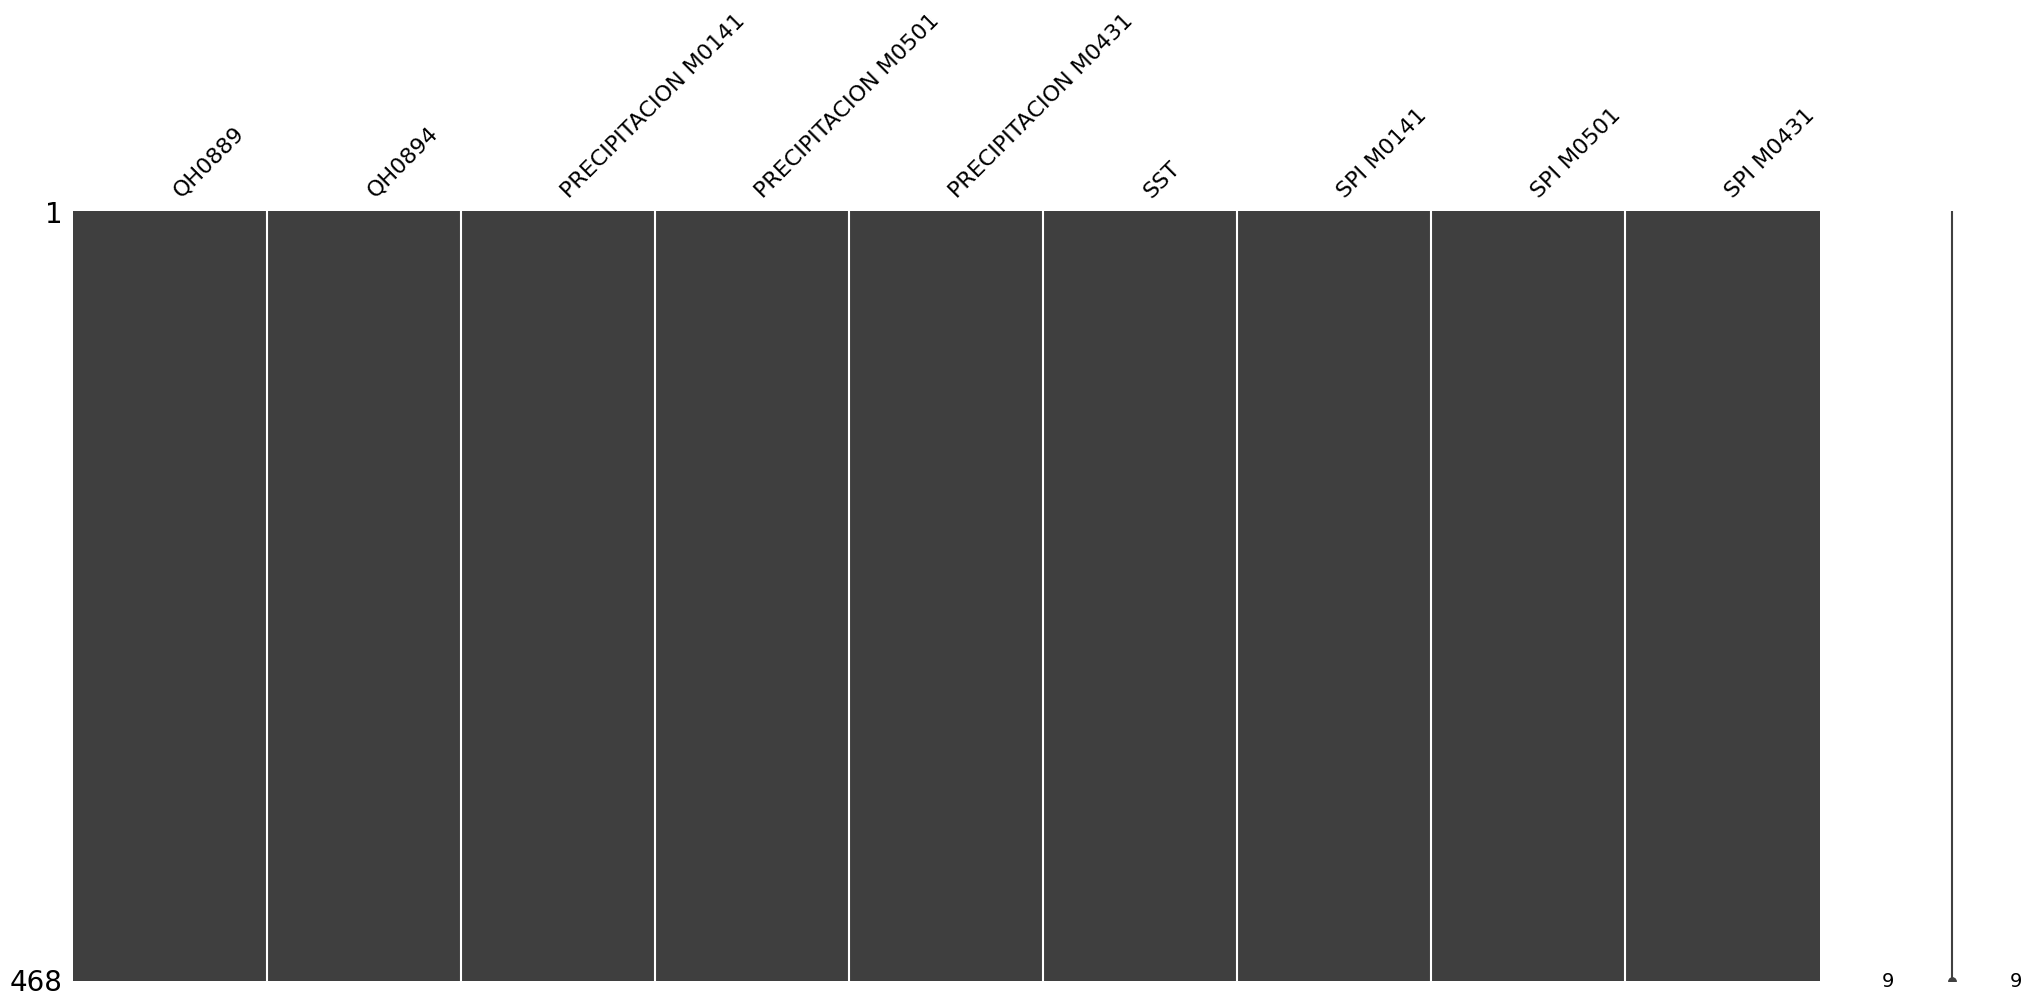

In [ ]:
msno.matrix(data_imputed)

La imagen a continuación muestra una serie de gráficos de líneas que comparan las **series temporales originales** (en azul) con los **valores imputados** (en naranja punteado) por un modelo, probablemente **SAITS**, tal como se mencionó antes. Aquí te dejo una **descripción breve de las series imputadas**, destacando el comportamiento general y la calidad de la imputación:

### 🔍 Análisis de imputación por variable

1. **QH0889**

   * Serie densa con muy pocos valores faltantes al final (2015–2018).
   * La imputación sigue bien la tendencia y la estacionalidad de los datos.

2. **QH0894**

   * Grandes segmentos faltantes en los primeros años (1978–1986 y 1991–1996).
   * La imputación reconstruye ciclos y niveles de variación plausibles, aunque con mayor suavidad.

3. **PRECIPITACIÓN M0141**

   * Datos ausentes dispersos en múltiples segmentos.
   * El modelo logra conservar los picos y estacionalidad sin distorsionar la forma general.

4. **PRECIPITACIÓN M0501**

   * Dos bloques extensos de valores faltantes (1985–1995 y 2010–2017).
   * Imputaciones coherentes con las oscilaciones originales, aunque algunos picos están suavizados.

5. **PRECIPITACIÓN M0431**

   * Faltantes frecuentes al inicio y final de la serie.
   * Imputación adecuada: captura amplitudes y periodos de alta variabilidad.

6. **SST** *(Temperatura superficial del mar)*

   * Casi sin datos faltantes.
   * La imputación sigue muy de cerca los datos reales, validando la robustez del modelo.

7. **SPI M0141, M0501 y M0431** *(Índices estandarizados de precipitación)*

   * Combinación de secciones completas y tramos faltantes.
   * Imputación logra mantener la distribución y rango de variabilidad, incluyendo valores extremos.


### 🧾 Conclusiones generales

* La imputación es **coherente con la dinámica temporal original**.
* Las **transiciones entre valores reales e imputados** son suaves, lo cual es positivo.
* Las imputaciones no generan artefactos ni tendencias artificiales.
* Las **series con más datos disponibles permiten una imputación más precisa** (ej. QH0889, SPI M0141).

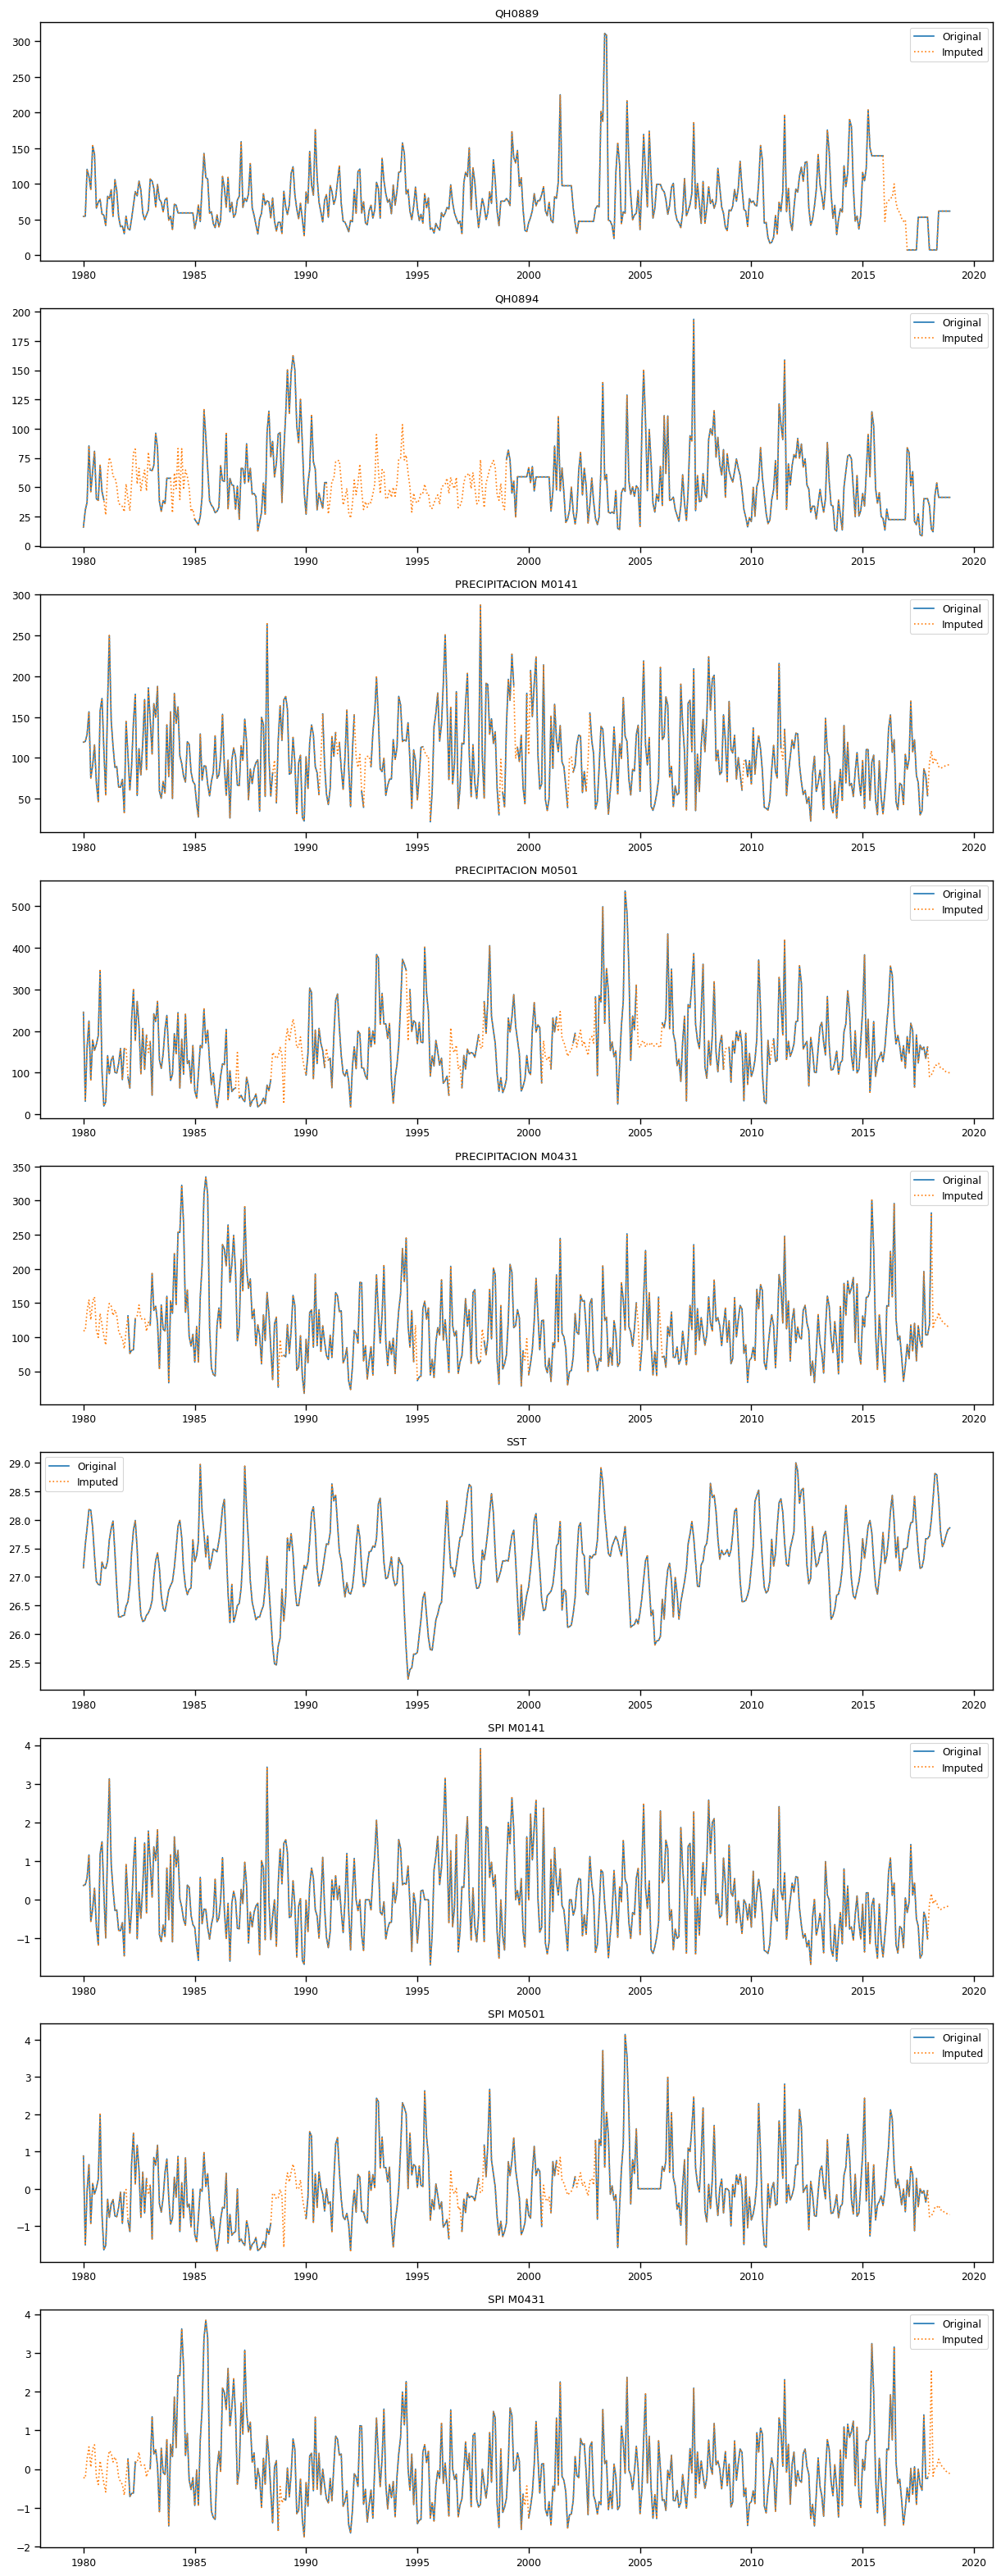

In [ ]:
import seaborn as sns
sns.set_context('paper')
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 40))

for i,col in enumerate(df.columns):
    plt.subplot(9,1,i+1)
    plt.plot(df.index, df[col], label="Original")
    plt.plot(data_imputed.index, data_imputed[col], ':', label="Imputed")
    plt.title(col)
    plt.legend()

In [ ]:
data_imputed.to_csv('dataset3_imputed.csv')

In [ ]:
import pandas as pd

# Read the CSV file with the specified date format and dayfirst=True
data_imputed = pd.read_csv('https://raw.githubusercontent.com/marsgr6/r-scripts/refs/heads/master/data/viz_data/ts_data_precipitation.csv',
                               parse_dates=[0], dayfirst=True, index_col=0)

# Display the first few rows of the DataFrame to verify
data_imputed.head()


QH0889  QH0894  PM0141  PM0501  PM0431    SST  SPI M0141  \
FECHA                                                                  
1980-01-01   54.52   15.78   119.3   245.5  105.94  27.16       0.37   
1980-02-01   54.67   30.41   120.2    31.4   92.91  27.57       0.39   
1980-03-01  120.46   37.04   128.8   161.2  118.66  27.85       0.57   
1980-04-01  110.47   85.36   156.6   224.3  138.17  28.18       1.16   
1980-05-01   92.28   46.10    75.3    82.8  103.27  28.17      -0.56   

            SPI M0501  SPI M0431  
FECHA                             
1980-01-01       0.88      -0.30  
1980-02-01      -1.51      -0.51  
1980-03-01      -0.06      -0.06  
1980-04-01       0.65       0.25  
1980-05-01      -0.93      -0.28

In [ ]:
# Convert 'FECHA' to datetime and set as index
df = pd.read_csv('https://raw.githubusercontent.com/marsgr6/r-scripts/refs/heads/master/data/dataset2_cuenca.csv')
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%Y-%m')
df.set_index('FECHA', inplace=True)
df.head()

QH0889  QH0894  PRECIPITACION M0141  PRECIPITACION M0501  \
FECHA                                                                   
1980-01-01   54.521  15.784                119.3                245.5   
1980-02-01   54.666  30.408                120.2                 31.4   
1980-03-01  120.460  37.035                128.8                161.2   
1980-04-01  110.465  85.364                156.6                224.3   
1980-05-01   92.278  46.099                 75.3                 82.8   

            PRECIPITACION M0431    SST  SPI M0141  SPI M0501  SPI M0431  
FECHA                                                                    
1980-01-01                  NaN  27.16       0.37       0.88        NaN  
1980-02-01                  NaN  27.57       0.39      -1.51        NaN  
1980-03-01                  NaN  27.85       0.57      -0.06        NaN  
1980-04-01                  NaN  28.18       1.16       0.65        NaN  
1980-05-01                  NaN  28.17      -0.56      -0.93        NaN

In [ ]:
# prompt: name the first 9 columns of df using the columns of data_imputed

# Assuming 'df' and 'data_imputed' are already defined as in your provided code.

# Check if the number of columns in 'data_imputed' is at least 9
if len(data_imputed.columns) >= 9:
  # Rename the first 9 columns of 'df'
  df.columns = list(data_imputed.columns[:9]) + list(df.columns[9:])
else:
  print("Error: 'data_imputed' does not have at least 9 columns.")

df.head()

QH0889  QH0894  PM0141  PM0501  PM0431    SST  SPI M0141  \
FECHA                                                                   
1980-01-01   54.521  15.784   119.3   245.5     NaN  27.16       0.37   
1980-02-01   54.666  30.408   120.2    31.4     NaN  27.57       0.39   
1980-03-01  120.460  37.035   128.8   161.2     NaN  27.85       0.57   
1980-04-01  110.465  85.364   156.6   224.3     NaN  28.18       1.16   
1980-05-01   92.278  46.099    75.3    82.8     NaN  28.17      -0.56   

            SPI M0501  SPI M0431  
FECHA                             
1980-01-01       0.88        NaN  
1980-02-01      -1.51        NaN  
1980-03-01      -0.06        NaN  
1980-04-01       0.65        NaN  
1980-05-01      -0.93        NaN

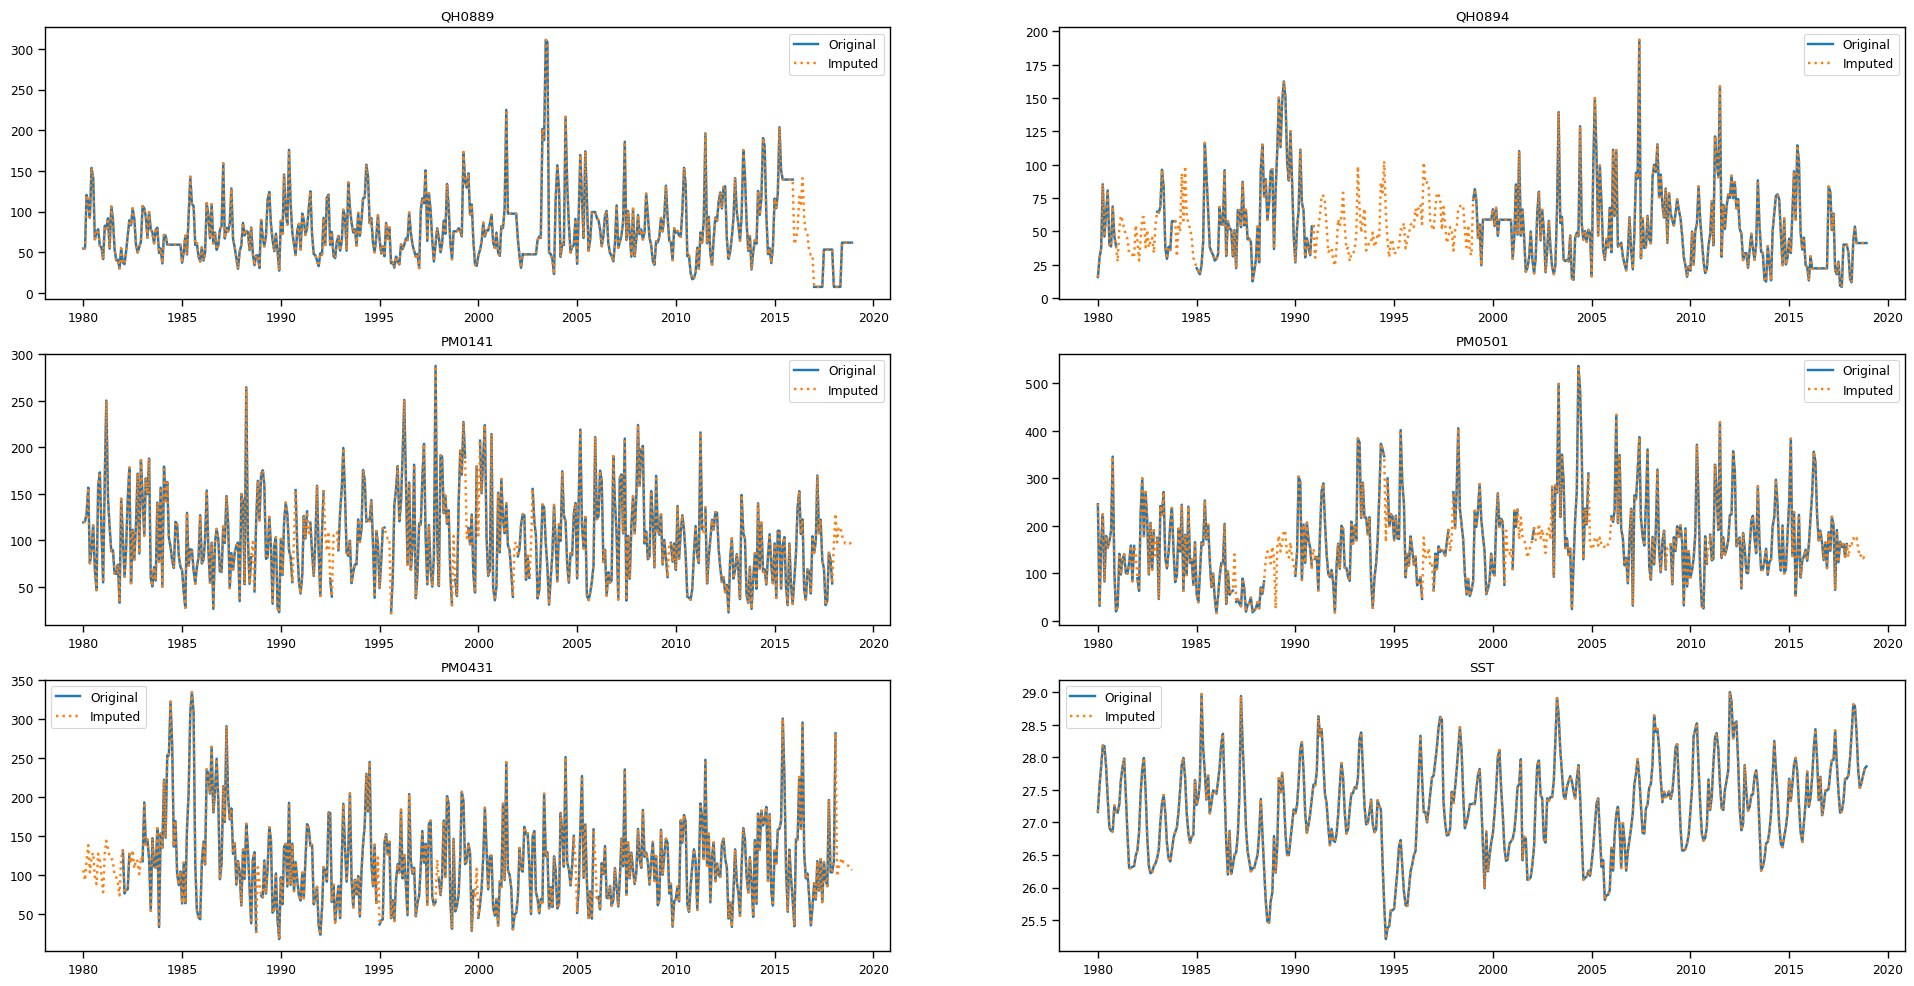

In [ ]:
import seaborn as sns
sns.set_context('paper')
import matplotlib.pyplot as plt
plt.figure(figsize=(24, 12))

for i,col in enumerate(df.columns[:6]):
    plt.subplot(3,2,i+1)
    plt.plot(df.index, df[col], label="Original", linewidth=1.75)
    plt.plot(data_imputed.index, data_imputed[col], ':', label="Imputed", linewidth=1.75)
    plt.title(col)
    plt.legend()

In [ ]:
import pandas as pd

# Read the CSV file with the specified date format and dayfirst=True
data_imputed = pd.read_csv('https://raw.githubusercontent.com/marsgr6/r-scripts/refs/heads/master/data/viz_data/ts_data_precipitation.csv',
                               parse_dates=[0], dayfirst=True, index_col=0)

# Display the first few rows of the DataFrame to verify
data = data_imputed.head().iloc[:,:5]
data.head()

QH0889  QH0894  PM0141  PM0501  PM0431
FECHA                                             
1980-01-01   54.52   15.78   119.3   245.5  105.94
1980-02-01   54.67   30.41   120.2    31.4   92.91
1980-03-01  120.46   37.04   128.8   161.2  118.66
1980-04-01  110.47   85.36   156.6   224.3  138.17
1980-05-01   92.28   46.10    75.3    82.8  103.27

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.8 MB/s eta 0:00:00


## 🔢 Modelo base: MLP Regressor estático (sin dinámica temporal)

Como primer enfoque, se ha entrenado un **modelo base** utilizando una red neuronal multicapa (MLP) implementada con `sklearn.neural_network.MLPRegressor`. Este modelo busca predecir el valor de una variable objetivo (por ejemplo, **PM0431**) a partir de las variables climáticas observadas en el mismo instante de tiempo.

### 🧠 Características del modelo

* **Modelo estático**: no considera información pasada de la serie (ni de la variable objetivo ni de los predictores). Es decir, **no hay dinámica temporal explícita**.
* Se entrena con una **división temporal 70/30**, respetando la secuencia cronológica.
* Se aplica **escalado (normalización estándar)** tanto a los predictores `X` como al valor objetivo `y`, para mejorar la estabilidad del entrenamiento.
* El modelo se entrena con `early_stopping` y una fracción de validación del 20% para evitar sobreajuste.

### ⚙️ Entrenamiento

La red neuronal cuenta con dos capas ocultas:

```python
MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, ...)
```

El entrenamiento se realiza con los datos escalados, y la predicción es transformada nuevamente a la escala original del target utilizando `inverse_transform`.


### 📊 Resultados

La gráfica siguiente muestra el desempeño del modelo sobre el conjunto de prueba. Se observa que, a pesar de ser un modelo estático, **logra seguir razonablemente bien la tendencia y amplitud** de la serie temporal en muchos tramos.

📈 **Visualización**:

* Azul: valores reales del conjunto de entrenamiento.
* Verde: valores reales del conjunto de prueba.
* Rojo punteado: predicciones del modelo sobre el conjunto de prueba.

![MLP Prediction Plot](https://raw.githubusercontent.com/marsgr6/r-scripts/refs/heads/master/imgs/mlp_ts_s4.png)


### ✅ Fortalezas del modelo

* Aunque no utiliza ventanas temporales ni memoria, **el modelo captura relaciones contemporáneas multivariadas** entre las variables de entrada y la variable objetivo.
* En este caso particular, el rendimiento ha sido **sorprendentemente bueno** en comparación con modelos temporales más complejos.


### ⚠️ Limitaciones

* **No puede modelar el futuro** si no se conocen los valores de entrada en ese futuro.
* Su capacidad de generalización dependerá en gran medida de la correlación contemporánea entre variables.


### 📌 Conclusión

Este modelo MLP estático sirve como una **línea base**, contra la cual se pueden comparar enfoques más avanzados que sí consideren la secuencia temporal (como LSTM o Transformers). A pesar de sus limitaciones teóricas, su rendimiento práctico sugiere que **las variables explicativas contemporáneas contienen información significativa** para predecir el target en el mismo instante.

MSE: 1743.48
RMSE: 41.75
R²: 0.29
MAE: 28.77


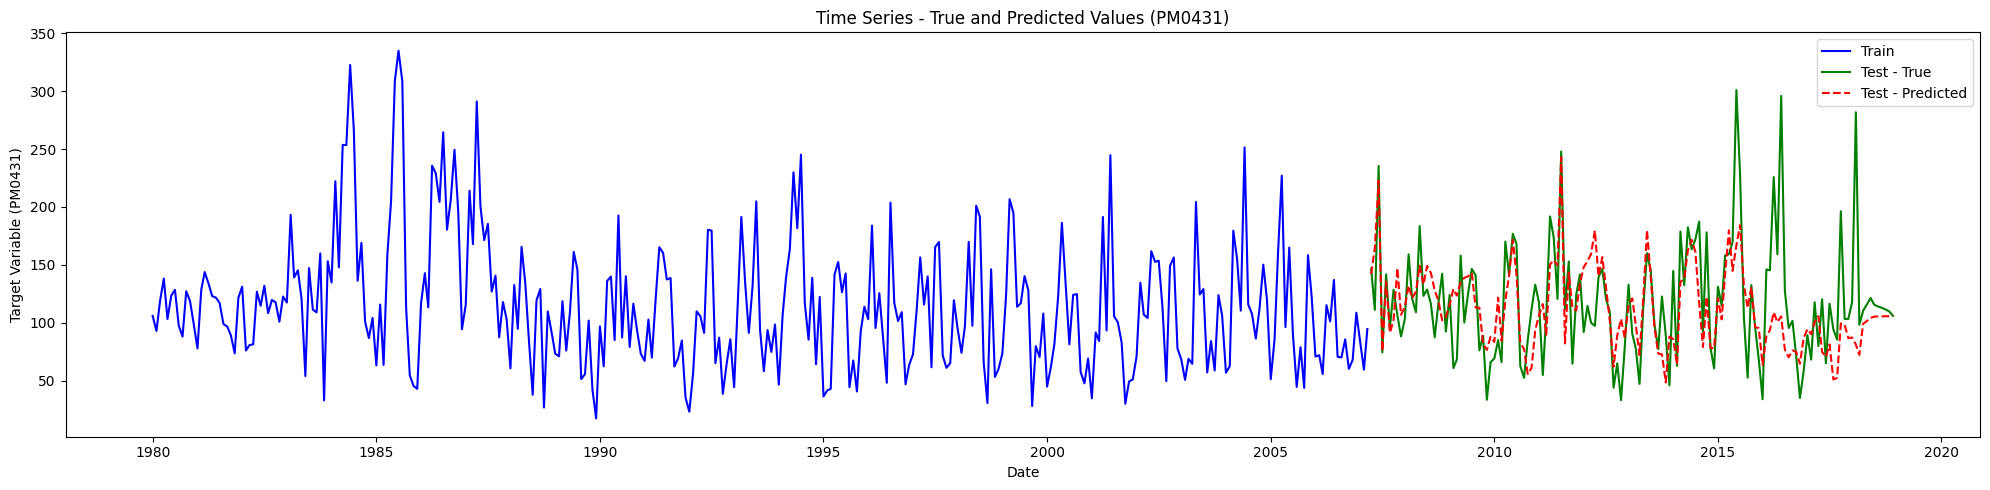

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load data
data = pd.read_csv(
    'https://raw.githubusercontent.com/marsgr6/r-scripts/refs/heads/master/data/viz_data/ts_data_precipitation.csv',
    parse_dates=[0], dayfirst=True, index_col=0)

data = data.iloc[:, :5]
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Time-based split
split_index = int(len(data) * 0.7)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Scale features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Define and fit MLP
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, early_stopping=True, validation_fraction=0.2)
mlp.fit(X_train_scaled, y_train_scaled)

# Predict
y_pred_scaled = mlp.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
assert len(y_test) == len(y_pred), "Test and prediction length mismatch"

# Evaluate
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {np.sqrt(mse):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")

# Plot
plt.figure(figsize=(20, 5))
plt.plot(y_train.index, y_train, label="Train", color='blue')
plt.plot(y_test.index, y_test, label="Test - True", color='green')
plt.plot(y_test.index, y_pred, label="Test - Predicted", color='red', linestyle='--')
plt.title("Time Series - True and Predicted Values (PM0431)")
plt.ylabel("Target Variable (PM0431)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

## 🔄 Modelo MLP con Dinámica Temporal: Uso de Lags como Variables

En esta segunda etapa, implementamos un modelo de red neuronal MLP que incorpora **información temporal de forma explícita**. Para lograrlo, se añaden **valores pasados (lags)** de todas las variables como nuevas entradas, lo que convierte al modelo en una forma de **predicción con ventana deslizante**. Aunque el MLP no es un modelo secuencial en sí, este enfoque permite que aprenda **relaciones temporales a corto plazo** de manera indirecta.

---

### 🧠 Comparación con el modelo anterior

| Característica              | Modelo Estático            | Modelo con Lags                       |
| --------------------------- | -------------------------- | ------------------------------------- |
| Input                       | Variables en el tiempo *t* | Variables en *t*, *t−1*, *t−2*, *t−3* |
| ¿Captura dinámica temporal? | ❌ No                       | ✅ Sí (por medio de lags)              |
| Tipo de modelo              | MLP clásico                | MLP clásico                           |
| Dependencia temporal        | No explícita               | Implícita mediante features           |


### ⚙️ Arquitectura del modelo

* Se construyen variables de entrada usando los **3 últimos valores de cada variable** (lag 1, 2 y 3).
* Esto proporciona al modelo un **contexto temporal fijo** de tamaño 3 para cada serie.
* La red neuronal se entrena con la siguiente configuración:

```python
MLPRegressor(hidden_layer_sizes=(100,), max_iter=500)
```

* El código para la generación de características temporales es:

```python
for col in df.columns:
    for lag in [1, 2, 3]:
        df_lagged[f'{col}_lag{lag}'] = df[col].shift(lag)
```

> Esta técnica enriquece el conjunto de variables sin recurrir a arquitecturas secuenciales como LSTM o Transformers.


### 📉 Desempeño del modelo

![MLP Lags PM2.5 Forecast](https://raw.githubusercontent.com/marsgr6/r-scripts/refs/heads/master/imgs/mlp_tf_ts_s4.png)

* 🔵 **Train**: valores reales del conjunto de entrenamiento
* 🟢 **True**: valores reales en el conjunto de prueba
* 🔴 **Predicted**: predicción del modelo sobre el conjunto de prueba

El modelo ahora intenta **predecir el valor futuro de la variable objetivo utilizando únicamente información pasada**, lo que representa un desafío mayor, pero también una evaluación más realista del rendimiento predictivo.


### 🧪 Evaluación

* Se utiliza `RMSE` (error cuadrático medio) y `R²` (coeficiente de determinación) como métricas principales.
* Aunque el modelo enfrenta mayor dificultad por la ausencia de información futura, **logra capturar patrones generales y algunos comportamientos estacionales**, aunque con menor precisión en los picos más abruptos.


### ✅ Ventajas

* Introduce **dinámica temporal explícita** sin requerir redes recurrentes.
* Es sencillo de implementar y fácil de interpretar.
* Es adecuado cuando solo se dispone del **historial de variables hasta el tiempo t**.


### ⚠️ Desventajas

* La ventana temporal es **estática y limitada**, lo que puede impedir la captura de relaciones de largo plazo.
* El número de variables crece rápidamente (dimensionalidad alta), lo que puede inducir **sobreajuste** si los datos son escasos.
* No realiza forecasting autoregresivo: **no alimenta sus propias predicciones como entradas futuras**.


### 📌 Conclusión

Este enfoque basado en **MLP con variables de retardo** es una forma efectiva de introducir información temporal en modelos densos tradicionales. Representa un buen punto de partida antes de avanzar hacia modelos secuenciales más sofisticados como LSTM o Transformers. Es útil para evaluar si la **historia reciente de las variables** contiene suficiente información para anticipar su evolución.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


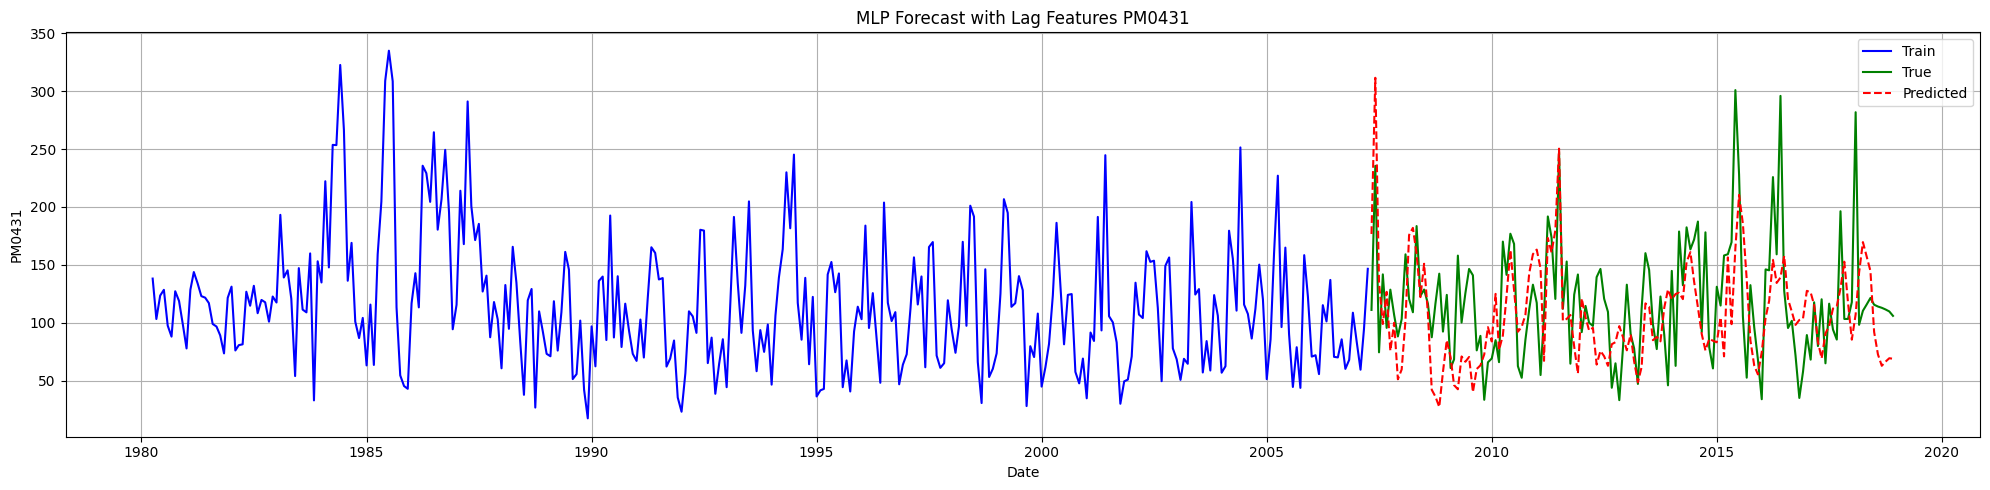

MSE: 2638.68
RMSE: 51.37
R²: -0.07
MAE: 41.18


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# --- Load Data ---
data = pd.read_csv(
    'https://raw.githubusercontent.com/marsgr6/r-scripts/refs/heads/master/data/viz_data/ts_data_precipitation.csv',
    parse_dates=[0], dayfirst=True, index_col=0
)

data = data.iloc[:, :5]  # Use only 5 columns
target_col = 'PM0431'    # Last column as target

# --- Create Lag Features (time modeling) ---
def create_lagged_features_all(df, lags=[1, 2, 3]):
    df_lagged = df.copy()
    for col in df.columns:
        for lag in lags:
            df_lagged[f'{col}_lag{lag}'] = df[col].shift(lag)
    df_lagged.dropna(inplace=True)
    return df_lagged

lags = [1, 2, 3]
data_lagged = create_lagged_features_all(data, lags)

# --- Train/Test Split ---
split_index = int(len(data_lagged) * 0.7)
train = data_lagged.iloc[:split_index]
test = data_lagged.iloc[split_index:]

X_train = train.drop(columns=[target_col])
y_train = train[target_col]
X_test = test.drop(columns=[target_col])
y_test = test[target_col]

# --- Scale Features ---
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# --- Train MLP Model ---
mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)

# --- Predict ---
y_pred = mlp.predict(X_test_scaled)
#y_pred = np.clip(y_pred, 0, None)  # avoid negatives

# --- Plot Results ---
plt.figure(figsize=(20, 5))
plt.plot(y_train.index, y_train, label='Train', color='blue')
plt.plot(y_test.index, y_test, label='True', color='green')
plt.plot(y_test.index, y_pred, label='Predicted', color='red', linestyle='--')
plt.title('MLP Forecast with Lag Features '+target_col)
plt.xlabel('Date')
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Evaluation ---
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {np.sqrt(mse):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")

## 📊 Evaluación del modelo MLP con lags: PM0431

El modelo MLP configurado con **lags como features** fue entrenado para predecir la variable de precipitación **PM0431**, utilizando una ventana de 3 pasos hacia atrás para cada variable predictora. El conjunto de entrenamiento cubre el 70% inicial de la serie y el 30% restante se utiliza para prueba.

### 🔢 Métricas de desempeño

| Métrica         | Valor   |
| --------------- | ------- |
| MSE             | 2638.68 |
| RMSE            | 51.37   |
| MAE             | 41.18   |
| R² (R-cuadrado) | −0.07   |


### 📈 Análisis visual

![Forecast plot](https://raw.githubusercontent.com/marsgr6/r-scripts/refs/heads/master/imgs/mlp_tf_ts_s4.png)

* **Azul**: datos de entrenamiento
* **Verde**: valores reales del conjunto de prueba
* **Rojo punteado**: predicción del modelo

Podemos observar que el modelo **logra capturar en términos generales el rango y la estacionalidad**, pero tiene **dificultades importantes para seguir los valores extremos** (especialmente los picos de alta precipitación después de 2010). Además, tiende a suavizar las oscilaciones, lo que indica cierta rigidez en su capacidad de respuesta a eventos bruscos.


### 🧪 Discusión de resultados

1. **Rendimiento global bajo (R² = −0.07)**
   El valor negativo de $R^2$ indica que el modelo **no mejora respecto a una predicción trivial** (por ejemplo, la media del target). Este es un indicio claro de **underfitting**: el modelo no está captando adecuadamente la complejidad de la señal.

2. **RMSE y MAE altos en comparación con la escala de la serie**
   Un RMSE de 51.37 sugiere errores sustanciales considerando que la mayoría de los valores reales de PM0431 están entre 0 y 300. El **MAE** de 41.18 indica que incluso los errores absolutos medios son significativos.

3. **Predicciones amortiguadas**
   El modelo tiende a **subestimar picos y sobreestimar valles**, un comportamiento típico de modelos densos como el MLP cuando:

   * La señal es altamente no lineal o ruidosa.
   * Los datos son insuficientes para representar bien los eventos extremos.
   * No se ha incorporado suficiente contexto temporal (puede requerir más lags o memoria secuencial).

### 🔍 Posibles causas del bajo rendimiento

* **Complejidad del fenómeno climático**: la precipitación es un proceso altamente estocástico y no lineal, difícil de modelar con ventanas cortas y modelos densos simples.
* **Ventana de tiempo limitada**: 3 lags pueden no ser suficientes para capturar estacionalidad o efectos de largo plazo.
* **Arquitectura simple**: una sola capa oculta puede ser insuficiente para representar relaciones complejas.
* **Distribución del target**: la serie puede estar desequilibrada, con muchos valores bajos y pocos extremos, lo que afecta el aprendizaje.


### 🛠️ Recomendaciones

* **Probar con modelos secuenciales como LSTM o Transformer**, que están mejor diseñados para aprender dependencias temporales de largo alcance.
* **Aumentar el número de lags** o construir características agregadas (media móvil, desvío estándar local).
* **Explorar transformaciones del target** (e.g., log-transform) para reducir el impacto de los extremos.
* **Evaluar regularización y arquitectura del MLP**: más capas, más neuronas o técnicas como dropout.


### 📌 Conclusión

Aunque este modelo de MLP con lags representa un paso hacia la incorporación de información temporal, su rendimiento en la predicción de **PM0431** sugiere que se requieren enfoques más potentes para captar la complejidad del fenómeno. Sirve como **línea base comparativa**, pero deja claro que es necesario avanzar hacia modelos más especializados en series temporales.

### A continuación

* **Prepararemos un modelo Transformer para comparar directamente.**

## 🧠 Arquitectura del Transformer para Series Temporales

El modelo implementado corresponde a una versión **simplificada y adaptada del Transformer** para tareas de predicción de series temporales univariadas. A diferencia de los Transformers originales para lenguaje natural, este está diseñado para trabajar con **ventanas fijas de datos multivariados** y producir una **única predicción futura**.


### 🔧 Arquitectura general

```text
Input (shape: n_steps × n_features)
  └── Dense layer (proyección al espacio d_model)
        └── Positional Encoding (seno y coseno)
              └── MultiHead Attention (self-attention)
                    └── Layer Normalization
                          └── GlobalAveragePooling1D
                                └── Dense (ReLU)
                                      └── Dense (output: 1)
```


### 🧩 Detalles por componente

| Componente                 | Descripción                                                         |
| -------------------------- | ------------------------------------------------------------------- |
| **Input Layer**            | Recibe una ventana temporal de forma `(n_steps, n_features)`        |
| **Dense (proyección)**     | Proyecta los inputs al espacio dimensional `d_model=32`             |
| **Positional Encoding**    | Añade codificación posicional usando funciones seno/coseno          |
| **Multi-Head Attention**   | Atención propia (self-attention) entre elementos de la secuencia    |
| **LayerNormalization**     | Estabiliza la salida de la capa de atención                         |
| **GlobalAveragePooling1D** | Reduce la secuencia a una sola representación agregada              |
| **Dense (ReLU)**           | Capa oculta intermedia con `dff=64` unidades y activación no lineal |
| **Dense (output)**         | Capa final que genera una única predicción (regresión escalar)      |


### ⚙️ Hiperparámetros

* **Tamaño de la ventana (n\_steps)**: 3 pasos temporales.
* **Dimensión del modelo (`d_model`)**: 32
* **Número de cabezas de atención (`num_heads`)**: 2
* **Tamaño del feed-forward (`dff`)**: 64
* **Épocas de entrenamiento**: 200
* **Optimizer**: Adam
* **Función de pérdida**: MSE


### 💡 Características importantes

* **Codificación Posicional**: implementada manualmente, añade información de orden en la secuencia.
* **Self-Attention**: el modelo aprende a enfocar partes específicas del historial reciente.
* **No autoregresivo**: el modelo predice el valor futuro sin retroalimentarse con sus propias predicciones.
* **Ventana deslizante**: similar a un forecasting basado en contexto, no en autoregresión paso a paso.


### 📉 Evaluación

* La predicción final es **una única salida escalar** por ventana.
* La evaluación se realiza sobre el conjunto de prueba (`30%` de la serie), y se visualiza sobre datos escalados.
* Se aplicó **inverse scaling** solo al target para calcular métricas reales como:

```python
RMSE: 52.13  
R²: -0.10
```

### 📌 Conclusión

Esta arquitectura muestra cómo los Transformers pueden ser adaptados para series temporales incluso en contextos simples. Sin embargo, **su efectividad depende fuertemente del volumen de datos, el diseño de ventanas y la sintonización fina**. Aunque la estructura permite capturar dependencias temporales complejas, en este caso particular **no logró superar modelos más simples como el MLP con lags**, posiblemente debido a restricciones en la cantidad de datos y la profundidad del modelo.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


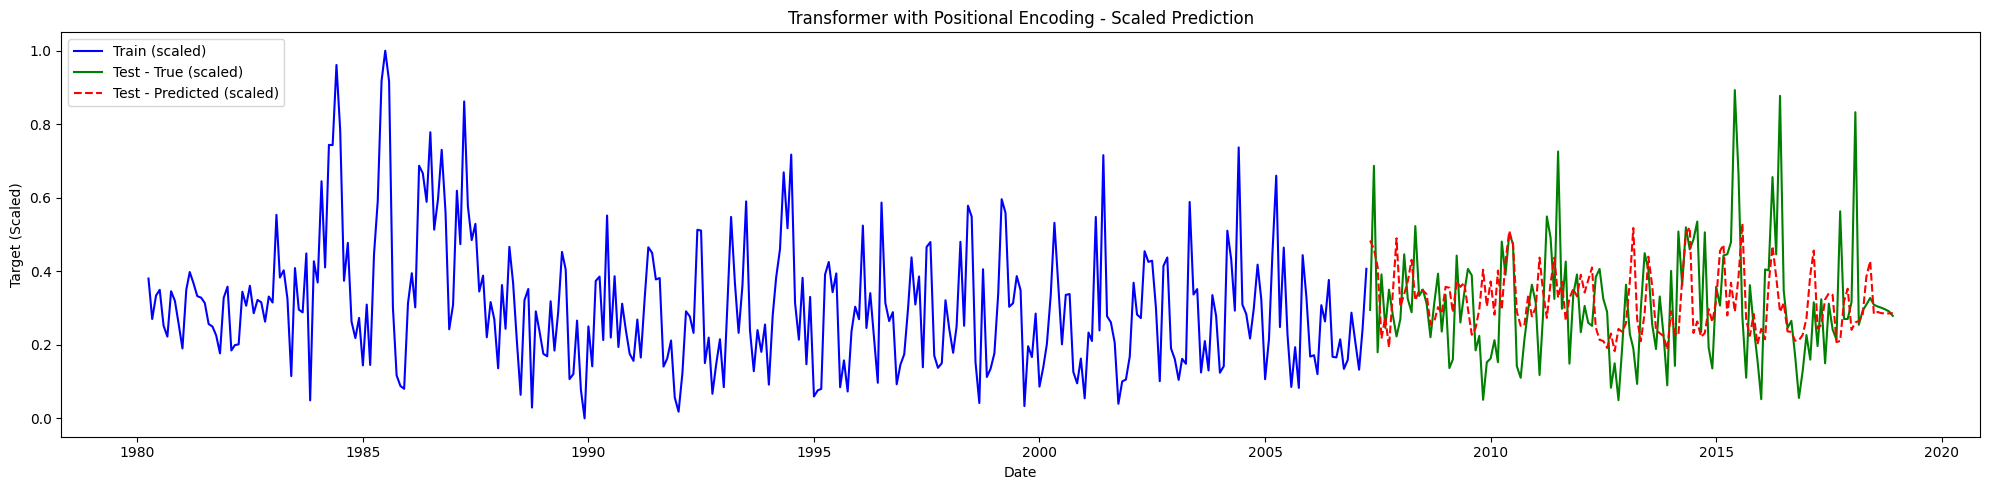

RMSE: 2718.76
R²: -0.10


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers

# Load data
data = pd.read_csv(
    'https://raw.githubusercontent.com/marsgr6/r-scripts/refs/heads/master/data/viz_data/ts_data_precipitation.csv',
    parse_dates=[0], dayfirst=True, index_col=0
).iloc[:, :5]

# Normalize all data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Sequence preparation
def create_sequences(data, n_steps=3):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i, :-1])  # features
        y.append(data[i, -1])               # target
    return np.array(X), np.array(y)

n_steps = 3
X_all, y_all = create_sequences(data_scaled, n_steps)

# Split
split_index = int(len(X_all) * 0.7)
X_train, X_test = X_all[:split_index], X_all[split_index:]
y_train, y_test = y_all[:split_index], y_all[split_index:]

# --- Positional Encoding Layer ---
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(sequence_length, d_model)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / tf.pow(10000., (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return pos * angle_rates

    def positional_encoding(self, sequence_length, d_model):
        angle_rads = self.get_angles(
            pos=tf.range(sequence_length, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model
        )
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        return pos_encoding[tf.newaxis, ...]

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# Define model
def build_transformer(n_steps, n_features, d_model=32, num_heads=2, dff=64):
    inputs = tf.keras.Input(shape=(n_steps, n_features))
    x = layers.Dense(d_model)(inputs)
    x = PositionalEncoding(n_steps, d_model)(x)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(dff, activation='relu')(x)
    outputs = layers.Dense(1)(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

model = build_transformer(n_steps, X_train.shape[2])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=200, verbose=0)

# Predict
y_pred = model.predict(X_test).flatten()

# Inverse scaling of target
target_scaler = MinMaxScaler()
target_scaler.min_, target_scaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
y_pred_inv = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Prepare date indices
dates = data.index[n_steps:]
train_dates = dates[:split_index]
test_dates = dates[split_index:]

# Plot
plt.figure(figsize=(20, 5))
plt.plot(train_dates, y_train, label="Train (scaled)", color='blue')
plt.plot(test_dates, y_test, label="Test - True (scaled)", color='green')
plt.plot(test_dates, y_pred, label="Test - Predicted (scaled)", color='red', linestyle='--')
plt.title("Transformer with Positional Encoding - Scaled Prediction")
plt.xlabel("Date")
plt.ylabel("Target (Scaled)")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation
rmse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

## 🤖 Modelo Transformer para Series Temporales – Escenario Escalado

Se implementó un modelo **Transformer** para predecir la variable **PM0431 (precipitación)**, utilizando ventanas temporales como secuencia de entrada. El modelo incorpora **codificación posicional**, permitiéndole entender el orden de las observaciones dentro de cada ventana, algo crucial en datos secuenciales.

### 🔢 Métricas de evaluación (con valores reales escalados)

| Métrica | Valor   |
| ------- | ------- |
| MSE     | 2718.76 |
| RMSE    | 52.13   |
| R²      | −0.10   |

---

### 📈 Análisis visual

![Transformer Scaled Forecast](https://raw.githubusercontent.com/marsgr6/r-scripts/refs/heads/master/imgs/transformer_tf_ts_s4.png)

* 🔵 **Train (scaled)**: datos reales del conjunto de entrenamiento (normalizados entre 0 y 1).
* 🟢 **Test - True (scaled)**: valores reales del conjunto de prueba.
* 🔴 **Test - Predicted (scaled)**: predicciones generadas por el modelo Transformer.


### 🧪 Interpretación

1. **Rendimiento bajo (R² < 0)**
   El valor negativo del coeficiente de determinación $R^2 = -0.10$ indica que el modelo Transformer, en este caso, **no logra superar un modelo trivial basado en la media** del target. Es decir, no hay una ganancia real en explicar la variabilidad del dato respecto a un baseline simple.

2. **Error cuadrático moderadamente alto**
   El **RMSE de 52.13** indica errores del mismo orden de magnitud que en el MLP con lags. El Transformer no logró mejorar significativamente ese desempeño, lo cual puede deberse a varios factores técnicos (ver más abajo).

3. **Predicciones suavizadas y tendencia centralizada**
   Visualmente, se observa que el modelo **sigue parcialmente la tendencia del target** pero tiene dificultades para capturar:

   * Picos abruptos (subestimación).
   * Valles profundos (sobreestimación).
   * Estacionalidad o patrones cíclicos más complejos.

   Este comportamiento es común cuando:

   * El modelo está subentrenado.
   * Hay overfitting a regiones más densas.
   * El número de parámetros del Transformer es alto en relación al tamaño de los datos.


### 📌 Fortalezas del enfoque Transformer

* Permite **capturar relaciones de largo plazo** mediante mecanismos de atención.
* La **codificación posicional** le da contexto temporal sin necesidad de recurrencia.
* Flexible para usar con entradas multivariadas.


### ⚠️ Limitaciones observadas

* **No mejora sobre el MLP con lags**, pese a su mayor complejidad.
* El rendimiento sugiere que **el modelo puede estar subajustado** (demasiado simple para aprender bien) o **sobreajustado** (demasiado complejo para el tamaño del dataset).
* Requiere una **tuning cuidadoso de hiperparámetros**: número de capas, cabezas de atención, tamaño de ventana, dropout, etc.


### 🧭 Recomendaciones

* **Aumentar la cantidad de datos de entrenamiento** (más ventanas) o usar aumento de datos (data augmentation) para mejorar la generalización.
* **Ajustar hiperparámetros**: reducir el número de capas o cabezas, o cambiar la longitud de la ventana temporal.
* Evaluar la posibilidad de **usar modelos híbridos**: Transformer + capas convolucionales o LSTM + atención.


### ✅ Conclusión

Aunque el Transformer es una arquitectura avanzada con capacidad para modelar dependencias a largo plazo, en este escenario específico **no ha logrado mejorar el desempeño del modelo MLP con lags**. Esto puede deberse al tamaño limitado de datos, hiperparámetros no óptimos, o a la alta variabilidad de la serie. Aun así, sirve como un punto de partida importante para explorar modelos más sofisticados o bien optimizados.

In [ ]:
# 3. Load and prepare data
data = pd.read_csv(
    'https://raw.githubusercontent.com/marsgr6/r-scripts/refs/heads/master/data/viz_data/ts_data_precipitation.csv',
    parse_dates=['FECHA'], dayfirst=True, index_col='FECHA'
)
data[data.columns[:-5]]

FECHA  QH0889  QH0894  PM0141  PM0501
0   1980-01-01   54.52   15.78  119.30  245.50
1   1980-02-01   54.67   30.41  120.20   31.40
2   1980-03-01  120.46   37.04  128.80  161.20
3   1980-04-01  110.47   85.36  156.60  224.30
4   1980-05-01   92.28   46.10   75.30   82.80
..         ...     ...     ...     ...     ...
463 2018-08-01   61.78   41.29   96.42  134.98
464 2018-09-01   61.78   41.29   96.79  139.45
465 2018-10-01   61.78   41.29   96.10  131.59
466 2018-11-01   61.78   41.29   96.70  138.36
467 2018-12-01   61.78   41.29   99.03  137.36

[468 rows x 5 columns]

In [ ]:
data.head(20)

QH0889  QH0894  PM0141  PM0501  PM0431
FECHA                                             
1980-01-01   54.52   15.78   119.3   245.5  105.94
1980-02-01   54.67   30.41   120.2    31.4   92.91
1980-03-01  120.46   37.04   128.8   161.2  118.66
1980-04-01  110.47   85.36   156.6   224.3  138.17
1980-05-01   92.28   46.10    75.3    82.8  103.27
1980-06-01  153.65   63.71    91.0   178.7  123.51
1980-07-01  141.59   80.77   116.0   154.0  128.45
1980-08-01   65.98   39.99    69.0   168.3   97.58
1980-09-01   74.51   38.70    46.4   189.5   88.05
1980-10-01   78.25   68.73   157.9   345.7  127.23
1980-11-01   57.88   46.31   172.9   103.8  118.84
1980-12-01   56.10   39.16   111.3    19.9   99.12
1981-01-01   41.52   27.34    54.8    29.9   77.85
1981-02-01   82.59   52.75   168.0   141.2  128.54
1981-03-01   79.13   61.74   250.1    97.4  143.81
1981-04-01   91.65   57.94   145.4   130.0  133.96
1981-05-01   54.31   51.65   114.5   140.1  123.01
1981-06-01  106.14   48.13    88.3   100.8  121.69
1981-07-01   90.24   44.20    89.5    99.3  117.01
1981-08-01   53.67   33.33    64.3   121.8   98.97

In [ ]:
data_lagged.head(20)

QH0889  QH0894  PM0141  PM0501  PM0431  QH0889_lag1  QH0889_lag2  \
FECHA                                                                          
1980-04-01  110.47   85.36   156.6   224.3  138.17       120.46        54.67   
1980-05-01   92.28   46.10    75.3    82.8  103.27       110.47       120.46   
1980-06-01  153.65   63.71    91.0   178.7  123.51        92.28       110.47   
1980-07-01  141.59   80.77   116.0   154.0  128.45       153.65        92.28   
1980-08-01   65.98   39.99    69.0   168.3   97.58       141.59       153.65   
1980-09-01   74.51   38.70    46.4   189.5   88.05        65.98       141.59   
1980-10-01   78.25   68.73   157.9   345.7  127.23        74.51        65.98   
1980-11-01   57.88   46.31   172.9   103.8  118.84        78.25        74.51   
1980-12-01   56.10   39.16   111.3    19.9   99.12        57.88        78.25   
1981-01-01   41.52   27.34    54.8    29.9   77.85        56.10        57.88   
1981-02-01   82.59   52.75   168.0   141.2  128.54        41.52        56.10   
1981-03-01   79.13   61.74   250.1    97.4  143.81        82.59        41.52   
1981-04-01   91.65   57.94   145.4   130.0  133.96        79.13        82.59   
1981-05-01   54.31   51.65   114.5   140.1  123.01        91.65        79.13   
1981-06-01  106.14   48.13    88.3   100.8  121.69        54.31        91.65   
1981-07-01   90.24   44.20    89.5    99.3  117.01       106.14        54.31   
1981-08-01   53.67   33.33    64.3   121.8   98.97        90.24       106.14   
1981-09-01   39.96   33.00    64.1   158.6   96.75        53.67        90.24   
1981-10-01   40.81   32.43    73.8    83.3   89.12        39.96        53.67   
1981-11-01   30.06   30.14    33.0   157.7   73.59        40.81        39.96   

            QH0889_lag3  QH0894_lag1  QH0894_lag2  QH0894_lag3  PM0141_lag1  \
FECHA                                                                         
1980-04-01        54.52        37.04        30.41        15.78        128.8   
1980-05-01        54.67        85.36        37.04        30.41        156.6   
1980-06-01       120.46        46.10        85.36        37.04         75.3   
1980-07-01       110.47        63.71        46.10        85.36         91.0   
1980-08-01        92.28        80.77        63.71        46.10        116.0   
1980-09-01       153.65        39.99        80.77        63.71         69.0   
1980-10-01       141.59        38.70        39.99        80.77         46.4   
1980-11-01        65.98        68.73        38.70        39.99        157.9   
1980-12-01        74.51        46.31        68.73        38.70        172.9   
1981-01-01        78.25        39.16        46.31        68.73        111.3   
1981-02-01        57.88        27.34        39.16        46.31         54.8   
1981-03-01        56.10        52.75        27.34        39.16        168.0   
1981-04-01        41.52        61.74        52.75        27.34        250.1   
1981-05-01        82.59        57.94        61.74        52.75        145.4   
1981-06-01        79.13        51.65        57.94        61.74        114.5   
1981-07-01        91.65        48.13        51.65        57.94         88.3   
1981-08-01        54.31        44.20        48.13        51.65         89.5   
1981-09-01       106.14        33.33        44.20        48.13         64.3   
1981-10-01        90.24        33.00        33.33        44.20         64.1   
1981-11-01        53.67        32.43        33.00        33.33         73.8   

            PM0141_lag2  PM0141_lag3  PM0501_lag1  PM0501_lag2  PM0501_lag3  \
FECHA                                                                         
1980-04-01        120.2        119.3        161.2         31.4        245.5   
1980-05-01        128.8        120.2        224.3        161.2         31.4   
1980-06-01        156.6        128.8         82.8        224.3        161.2   
1980-07-01         75.3        156.6        178.7         82.8        224.3   
1980-08-01         91.0         75.3  

In [ ]:
data.tail(10)

QH0889  QH0894  PM0141  PM0501  PM0431
FECHA                                             
2018-03-01    7.38   11.84   97.73  160.64   98.26
2018-04-01    7.38   43.03  113.16  174.43  110.37
2018-05-01    7.38   53.63  114.28  168.91  115.70
2018-06-01   61.78   41.29  105.03  174.37  121.43
2018-07-01   61.78   41.29  100.25  152.02  115.60
2018-08-01   61.78   41.29   96.42  134.98  114.03
2018-09-01   61.78   41.29   96.79  139.45  112.94
2018-10-01   61.78   41.29   96.10  131.59  111.53
2018-11-01   61.78   41.29   96.70  138.36  109.80
2018-12-01   61.78   41.29   99.03  137.36  105.97

In [ ]:
data_lagged.tail(10)

QH0889  QH0894  PM0141  PM0501  PM0431  PM0501_lag1
FECHA                                                          
2018-03-01    7.38   11.84   97.73  160.64   98.26       164.00
2018-04-01    7.38   43.03  113.16  174.43  110.37       160.64
2018-05-01    7.38   53.63  114.28  168.91  115.70       174.43
2018-06-01   61.78   41.29  105.03  174.37  121.43       168.91
2018-07-01   61.78   41.29  100.25  152.02  115.60       174.37
2018-08-01   61.78   41.29   96.42  134.98  114.03       152.02
2018-09-01   61.78   41.29   96.79  139.45  112.94       134.98
2018-10-01   61.78   41.29   96.10  131.59  111.53       139.45
2018-11-01   61.78   41.29   96.70  138.36  109.80       131.59
2018-12-01   61.78   41.29   99.03  137.36  105.97       138.36

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        #seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        seq_x, seq_y = sequences[i:end_ix,:], sequences[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
dataset = np.hstack([data[[col]] for col in data.columns])
dataset.shape

(468, 5)

In [ ]:
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)

(465, 3, 5) (465,)


In [ ]:
X[1], y[1]

(array([[ 54.67,  30.41, 120.2 ,  31.4 ,  92.91],
        [120.46,  37.04, 128.8 , 161.2 , 118.66],
        [110.47,  85.36, 156.6 , 224.3 , 138.17]]),
 np.float64(103.27))

In [ ]:
data.head()

QH0889  QH0894  PM0141  PM0501  PM0431
FECHA                                             
1980-01-01   54.52   15.78   119.3   245.5  105.94
1980-02-01   54.67   30.41   120.2    31.4   92.91
1980-03-01  120.46   37.04   128.8   161.2  118.66
1980-04-01  110.47   85.36   156.6   224.3  138.17
1980-05-01   92.28   46.10    75.3    82.8  103.27

## 🧪 Ejercicio: Modelado predictivo de PM2.5 a partir de variables meteorológicas

Se proporciona un conjunto de datos de series temporales con variables medidas diariamente en una estación ambiental. Cada registro incluye:

* `DATE`: Fecha de la medición.
* `PRECIPITATION(mm)`: Precipitación total diaria en milímetros.
* `WINDDIR(deg)`: Dirección del viento en grados.
* `WINDSPEED(m/s)`: Velocidad del viento en metros por segundo.
* `PARTICULAS(microg/m3)`: Concentración de partículas finas (PM2.5) en el aire, en microgramos por metro cúbico.


### 🎯 Objetivo

Desarrollar un modelo de aprendizaje supervisado que permita **predecir la concentración de partículas PM2.5 (`PARTICULAS(microg/m3)`)** a partir de las condiciones meteorológicas actuales y pasadas.


### 📌 Actividades

1. **Preprocesamiento**

   * Cargar y convertir la variable `DATE` a tipo datetime.
   * Verificar y gestionar los valores faltantes (por ejemplo, mediante imputación KNN).
   * Escalar las variables si es necesario (por ejemplo, con `MinMaxScaler` o `StandardScaler`).

2. **Construcción de features**

   * Crear variables de *lag* para `PRECIPITATION`, `WINDDIR`, `WINDSPEED` (por ejemplo, lags de 1 a 3 días).
   * (Opcional) Incluir características adicionales como día de la semana, mes, etc.

3. **Modelado**

   * Entrenar un modelo MLP u otro regresor (Random Forest, LSTM, etc.) para predecir `PM2.5` a partir de las variables seleccionadas.
   * Realizar una división temporal del 70% entrenamiento / 30% prueba.
   * Evaluar el modelo con métricas como `RMSE`, `MAE`, `R²`.

4. **Visualización**

   * Graficar la serie temporal con las predicciones comparadas con los valores reales.
   * (Opcional) Marcar los valores imputados si se usó alguna técnica de completado de datos.


### 💡 Sugerencia avanzada (opcional)

Aplicar un modelo Transformer o LSTM para explorar si el uso de memoria temporal explícita mejora la capacidad predictiva respecto al MLP con lags fijos.

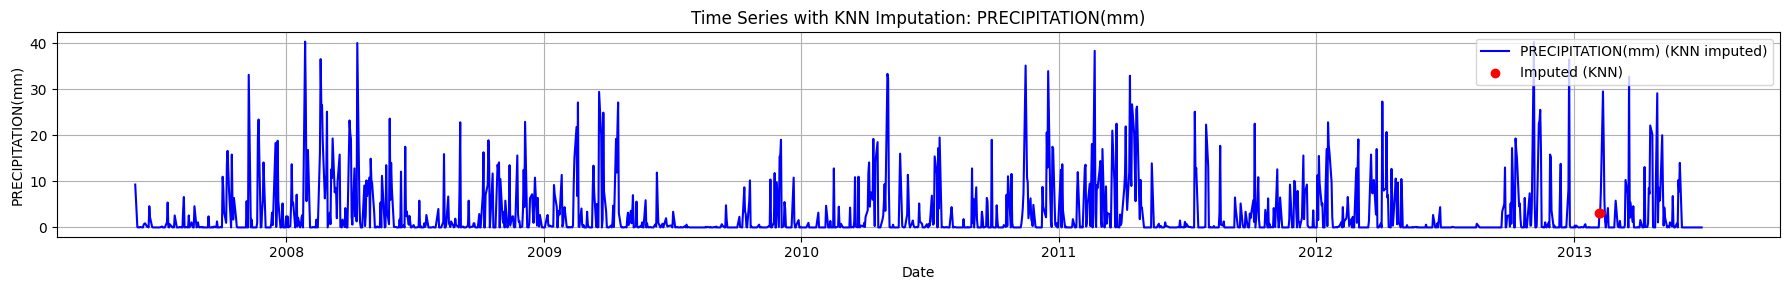

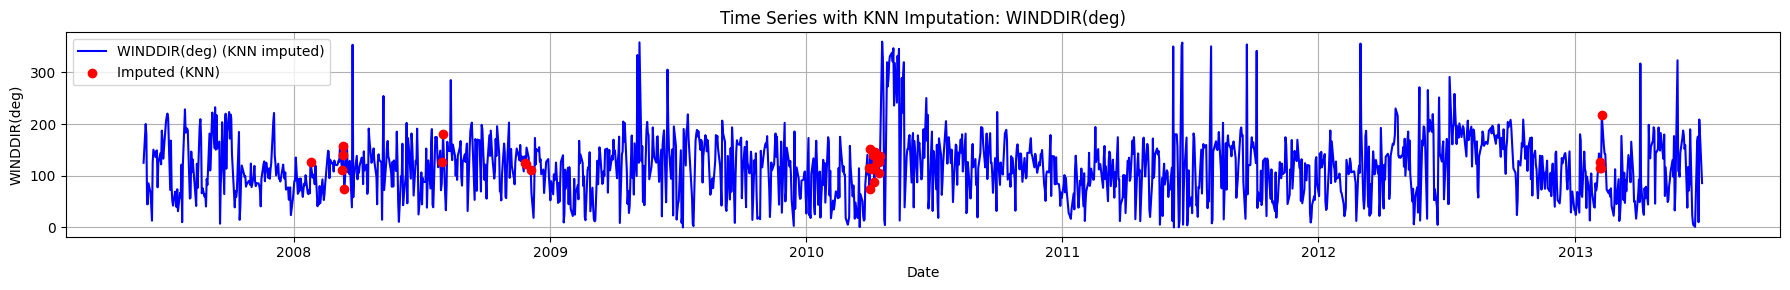

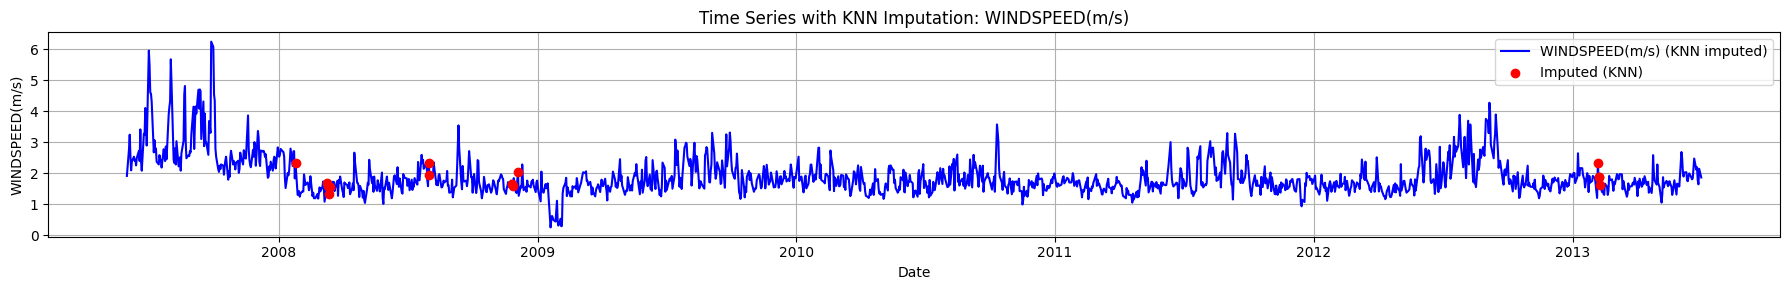

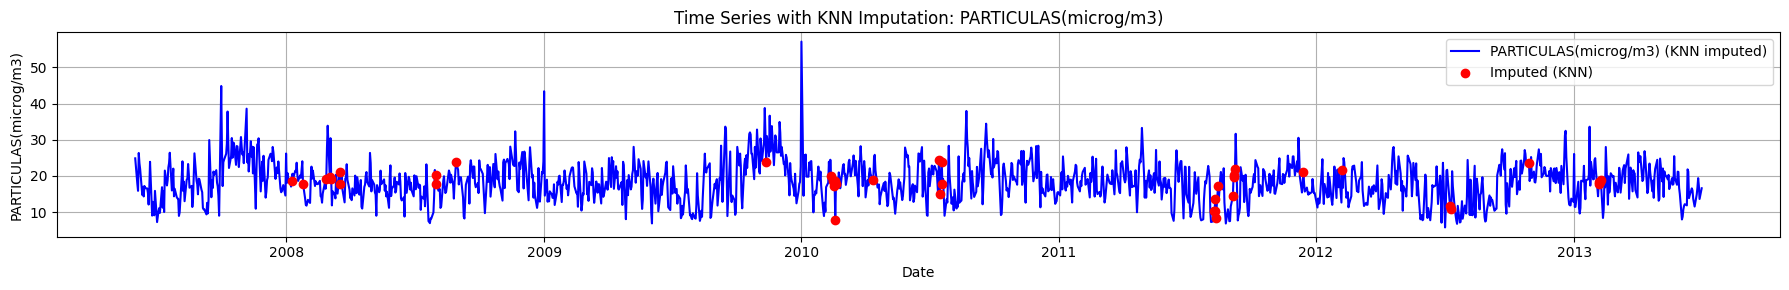

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import numpy as np

# Load the dataset
df = pd.read_csv("https://raw.githubusercontent.com/marsgr6/EN-online/refs/heads/main/data/Belisario_missing_values.csv",
                   parse_dates=["DATE"], dayfirst=True, index_col="DATE")

# Save mask of missing values before imputation
missing_mask = df.isna()

# KNN Imputation
imputer = KNNImputer(n_neighbors=2)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)

# Plot each time series with red markers for imputed points
for col in df.columns:
    plt.figure(figsize=(18, 3))
    plt.plot(df_imputed.index, df_imputed[col], label=f"{col} (KNN imputed)", color='blue')

    if missing_mask[col].any():
        plt.scatter(
            df_imputed.index[missing_mask[col]],
            df_imputed[col][missing_mask[col]],
            color='red',
            label='Imputed (KNN)',
            zorder=5
        )

    plt.title(f"Time Series with KNN Imputation: {col}")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 122.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.2 MB/s eta 0:00:00


[Transformer128] Epoch 1, Loss: 0.0358
[Transformer128] Epoch 2, Loss: 0.0008
[Transformer128] Epoch 3, Loss: 0.0005
[Transformer128] Epoch 4, Loss: 0.0005
[Transformer128] Epoch 5, Loss: 0.0005
[Transformer128] Epoch 6, Loss: 0.0005
[Transformer128] Epoch 7, Loss: 0.0005
[Transformer128] Epoch 8, Loss: 0.0005
[Transformer128] Epoch 9, Loss: 0.0004
[Transformer128] Epoch 10, Loss: 0.0004
[Transformer128] Epoch 11, Loss: 0.0004
[Transformer128] Epoch 12, Loss: 0.0004
[Transformer128] Epoch 13, Loss: 0.0003
[Transformer128] Epoch 14, Loss: 0.0004
[Transformer128] Epoch 15, Loss: 0.0003
[Transformer128] Epoch 16, Loss: 0.0004
[Transformer128] Epoch 17, Loss: 0.0003
[Transformer128] Epoch 18, Loss: 0.0003
[Transformer128] Epoch 19, Loss: 0.0003
[Transformer128] Epoch 20, Loss: 0.0004
[Transformer128] Epoch 21, Loss: 0.0004
[Transformer128] Epoch 22, Loss: 0.0003
[Transformer128] Epoch 23, Loss: 0.0003
[Transformer128] Epoch 24, Loss: 0.0003
[Transformer128] Epoch 25, Loss: 0.0004
[Transfor

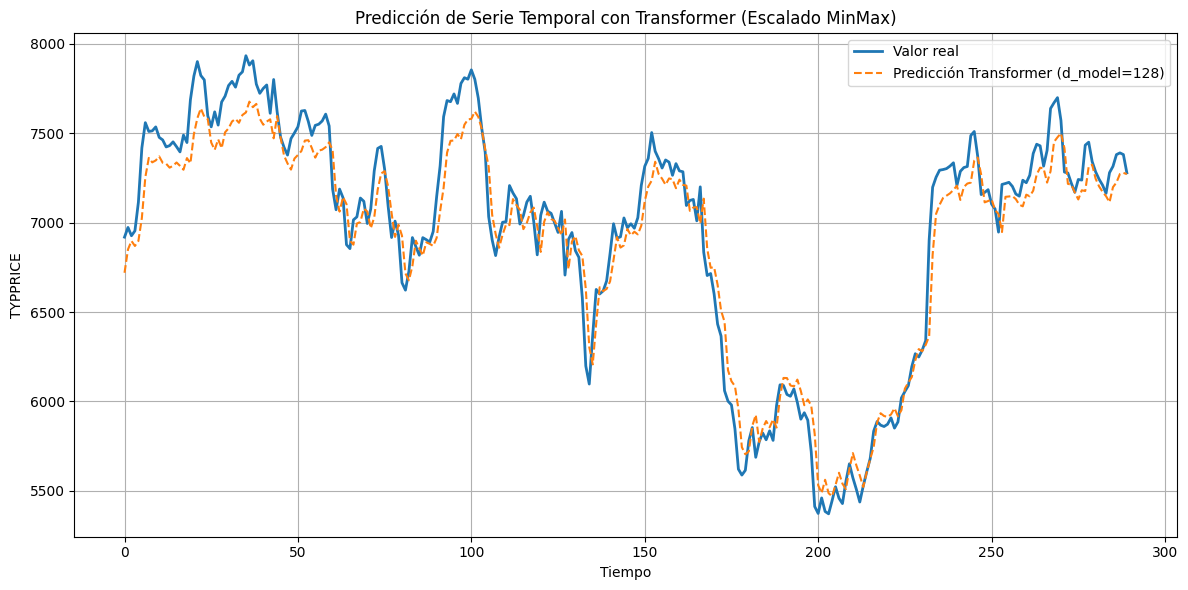

RMSE: 159.67
MAE: 127.16
MAPE: 1.81%
R²: 0.9427


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load and prepare the data
url = "https://raw.githubusercontent.com/marsgr6/ml-online/main/data/BAJFINANCE_day__with_indicators_.csv"
df = pd.read_csv(url, parse_dates=["date"])
series = df["TYPPRICE"].dropna().values
train_series = series[:-300]
test_series = series[-300:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_series.reshape(-1, 1)).flatten()
test_scaled = scaler.transform(test_series.reshape(-1, 1)).flatten()

# Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        return (self.data[idx:idx+self.seq_length],
                self.data[idx+self.seq_length])

seq_len = 10
train_dataset = TimeSeriesDataset(train_scaled, seq_len)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Transformer model with custom encoder layer
class TransformerTimeSeries(nn.Module):
    def __init__(self, seq_length, d_model=32, nhead=2, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=0.01,
            dim_feedforward=512,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)              # (B, L) → (B, L, 1)
        x = self.embedding(x)            # (B, L, 1) → (B, L, d_model)
        x = self.transformer(x)          # (B, L, d_model)
        x = x[:, -1, :]                  # Usar último token
        return self.fc(x).squeeze(-1)    # (B,)

# Model training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerTimeSeries(seq_length=seq_len).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(30):
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Transformer128] Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation
def create_test_windows(data, seq_length):
    return torch.stack([data[i:i+seq_length] for i in range(len(data) - seq_length)])

model.eval()
with torch.no_grad():
    test_tensor = torch.tensor(test_scaled, dtype=torch.float32)
    test_inputs = create_test_windows(test_tensor, seq_len).to(device)
    predictions = model(test_inputs).cpu().numpy()
    predictions_original = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

# Metrics
real = test_series[seq_len:]
rmse = np.sqrt(mean_squared_error(real, predictions_original))
mae = mean_absolute_error(real, predictions_original)
mape = np.mean(np.abs((real - predictions_original) / real)) * 100
r2 = r2_score(real, predictions_original)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(real, label="Valor real", linewidth=2)
plt.plot(predictions_original, label="Predicción Transformer (d_model=128)", linestyle="--")
plt.title("Predicción de Serie Temporal con Transformer (Escalado MinMax)")
plt.xlabel("Tiempo")
plt.ylabel("TYPPRICE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

In [ ]:
len(predictions_original)

300

[MultiStep] Epoch 1, Loss: 0.1855
[MultiStep] Epoch 2, Loss: 0.0057
[MultiStep] Epoch 3, Loss: 0.0039
[MultiStep] Epoch 4, Loss: 0.0033
[MultiStep] Epoch 5, Loss: 0.0026
[MultiStep] Epoch 6, Loss: 0.0022
[MultiStep] Epoch 7, Loss: 0.0021
[MultiStep] Epoch 8, Loss: 0.0020
[MultiStep] Epoch 9, Loss: 0.0015
[MultiStep] Epoch 10, Loss: 0.0014
[MultiStep] Epoch 11, Loss: 0.0013
[MultiStep] Epoch 12, Loss: 0.0011
[MultiStep] Epoch 13, Loss: 0.0012
[MultiStep] Epoch 14, Loss: 0.0011
[MultiStep] Epoch 15, Loss: 0.0009
[MultiStep] Epoch 16, Loss: 0.0010
[MultiStep] Epoch 17, Loss: 0.0009
[MultiStep] Epoch 18, Loss: 0.0009
[MultiStep] Epoch 19, Loss: 0.0008
[MultiStep] Epoch 20, Loss: 0.0007
[MultiStep] Epoch 21, Loss: 0.0007
[MultiStep] Epoch 22, Loss: 0.0006
[MultiStep] Epoch 23, Loss: 0.0008
[MultiStep] Epoch 24, Loss: 0.0006
[MultiStep] Epoch 25, Loss: 0.0005
[MultiStep] Epoch 26, Loss: 0.0007
[MultiStep] Epoch 27, Loss: 0.0008
[MultiStep] Epoch 28, Loss: 0.0007
[MultiStep] Epoch 29, Loss: 0

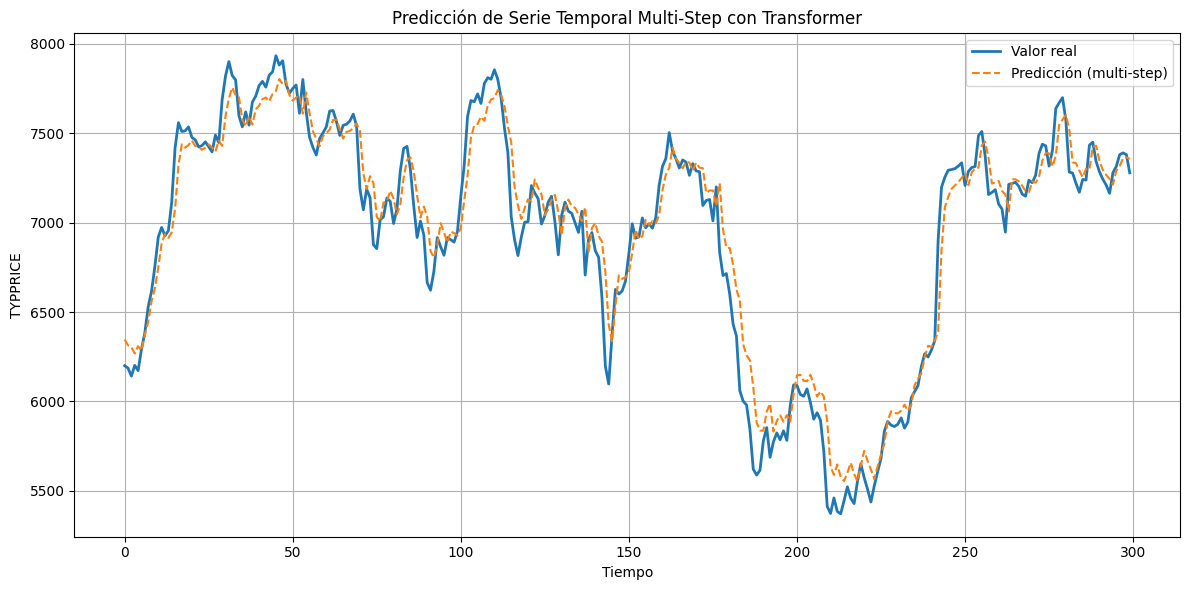

RMSE: 152.16
MAE: 114.18
MAPE: 1.70%
R²: 0.9478


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load and preprocess data
url = "https://raw.githubusercontent.com/marsgr6/ml-online/main/data/BAJFINANCE_day__with_indicators_.csv"
df = pd.read_csv(url, parse_dates=["date"])
series = df["TYPPRICE"].dropna().values

# Parameters
seq_len = 10
horizon = 1
train_series = series[:-300]
test_series = series[-300:]

# Scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_series.reshape(-1, 1)).flatten()
test_scaled = scaler.transform(test_series.reshape(-1, 1)).flatten()
full_test_input = np.concatenate([train_scaled[-seq_len:], test_scaled])

# Dataset for multi-step
class MultiStepTimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length, horizon):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_length = seq_length
        self.horizon = horizon

    def __len__(self):
        return len(self.data) - self.seq_length - self.horizon + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length]
        y = self.data[idx + self.seq_length : idx + self.seq_length + self.horizon]
        return x, y

# Prepare training
train_dataset = MultiStepTimeSeriesDataset(train_scaled, seq_len, horizon)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Transformer model with custom encoder layer
class TransformerTimeSeries(nn.Module):
    def __init__(self, seq_length, d_model=32, nhead=2, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=0.01,
            dim_feedforward=512,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, horizon)

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.embedding(x)
        x = self.transformer(x)
        x = x[:, -1, :]
        return self.fc(x)

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiStepTransformer(seq_length=seq_len, horizon=horizon).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(30):
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[MultiStep] Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation
def create_multi_step_test_windows(data, seq_length, horizon):
    return torch.stack([data[i:i+seq_length] for i in range(len(data) - seq_length - horizon + 1)])

test_tensor = torch.tensor(full_test_input, dtype=torch.float32)
test_inputs = create_multi_step_test_windows(test_tensor, seq_len, horizon).to(device)

model.eval()
with torch.no_grad():
    preds = model(test_inputs).cpu().numpy()

# Flatten predictions and compare
predictions_flat = preds.flatten()
true_flat = test_series[:len(predictions_flat)]
predictions_original = scaler.inverse_transform(predictions_flat.reshape(-1, 1)).flatten()

# Metrics
rmse = np.sqrt(mean_squared_error(true_flat, predictions_original))
mae = mean_absolute_error(true_flat, predictions_original)
mape = np.mean(np.abs((true_flat - predictions_original) / true_flat)) * 100
r2 = r2_score(true_flat, predictions_original)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(true_flat, label="Valor real", linewidth=2)
plt.plot(predictions_original, label="Predicción (multi-step)", linestyle="--")
plt.title("Predicción de Serie Temporal Multi-Step con Transformer")
plt.xlabel("Tiempo")
plt.ylabel("TYPPRICE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

In [ ]:
len(predictions_original)

300

In [ ]:
# Re-execute the full multivariate Transformer model due to reset
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load multivariate dataset
url = "https://raw.githubusercontent.com/marsgr6/ml-online/main/data/BAJFINANCE_day__with_indicators_.csv"
df = pd.read_csv(url, parse_dates=["date"])
df = df.dropna()

# Features and target
features = ['TYPPRICE', 'SMA_5', 'EMA_5', 'RSI_14', 'MACD', 'UPPER_BB', 'LOWER_BB']
data = df[features].values

# Train/test split
seq_len = 10
train_data = data[:-300]
test_data = data[-300:]

# Normalize all variables jointly
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Combine last `seq_len` from training with test for prediction
full_test_input = np.concatenate([train_scaled[-seq_len:], test_scaled])

# Dataset for multivariate input
class MultivariateTimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length, :]
        y = self.data[idx + self.seq_length, 0]  # predict TYPPRICE only
        return x, y

# Prepare training set
train_dataset = MultivariateTimeSeriesDataset(train_scaled, seq_len)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Transformer model for multivariate input
class MultivariateTransformer(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=0.1,
            dim_feedforward=256, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x)     # (B, L, input_dim) → (B, L, d_model)
        x = self.transformer(x)   # (B, L, d_model)
        x = x[:, -1, :]           # último token
        return self.fc(x).squeeze(-1)

# Train model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultivariateTransformer(input_dim=len(features)).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(10):
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Multivariate] Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation
def create_multivariate_windows(data, seq_length):
    return torch.stack([torch.tensor(data[i:i+seq_length], dtype=torch.float32)
                        for i in range(len(data) - seq_length)])

test_inputs = create_multivariate_windows(full_test_input, seq_len).to(device)

model.eval()
with torch.no_grad():
    predictions = model(test_inputs).cpu().numpy()
    predictions_original = scaler.inverse_transform(
        np.hstack([predictions.reshape(-1, 1), np.zeros((len(predictions), len(features) - 1))])
    )[:, 0]

# Ground truth
real = test_data[seq_len:, 0]

# Metrics
rmse = np.sqrt(mean_squared_error(real, predictions_original))
mae = mean_absolute_error(real, predictions_original)
mape = np.mean(np.abs((real - predictions_original) / real)) * 100
r2 = r2_score(real, predictions_original)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(real, label="Valor real", linewidth=2)
plt.plot(predictions_original, label="Predicción multivariada Transformer", linestyle="--")
plt.title("Predicción de Serie Temporal Multivariada con Transformer")
plt.xlabel("Tiempo")
plt.ylabel("TYPPRICE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import numpy as np

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Hyperparameters ---
config = {
    "batch_size": 64,
    "lr": 3e-4,
    "epochs": 30,
    "image_size": 128,
    "patch_size": 8,
    "num_classes": 10,
    "weight_decay": 0.01,
    "dropout": 0.2,
    "embed_dim": 64,
    "num_heads": 8,
    "num_layers": 6,
    "ff_dim": 512
}

# --- Enhanced Data Augmentation ---
train_transform = transforms.Compose([
    transforms.Resize(config["image_size"]),
    transforms.RandomCrop(config["image_size"], padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # CIFAR-10 stats
])

test_transform = transforms.Compose([
    transforms.Resize(config["image_size"]),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# --- Data Loading ---
train_data = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)
test_data = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

train_loader = DataLoader(
    train_data,
    batch_size=config["batch_size"],
    shuffle=True,
    pin_memory=True,
    num_workers=2
)
test_loader = DataLoader(
    test_data,
    batch_size=config["batch_size"],
    pin_memory=True,
    num_workers=2
)

# --- Improved Model Architecture ---
class FastViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = nn.Sequential(
            nn.Conv2d(3, config["embed_dim"],
                     kernel_size=config["patch_size"],
                     stride=config["patch_size"]),
            nn.LayerNorm([config["embed_dim"],
                         config["image_size"]//config["patch_size"],
                         config["image_size"]//config["patch_size"]])
        )
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=config["embed_dim"],
                nhead=config["num_heads"],
                dim_feedforward=config["ff_dim"],
                dropout=config["dropout"],
                batch_first=True,
                norm_first=True  # Pre-norm architecture
            ),
            num_layers=config["num_layers"]
        )
        self.head = nn.Sequential(
            nn.LayerNorm(config["embed_dim"]),
            nn.Linear(config["embed_dim"], 256),
            nn.GELU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(256, config["num_classes"])
        )

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2).permute(0, 2, 1)
        x = self.transformer(x)
        return self.head(x.mean(dim=1))

# --- Training Setup ---
model = FastViT().to(device)
optimizer = optim.AdamW(
    model.parameters(),
    lr=config["lr"],
    weight_decay=config["weight_decay"]
)
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=config["epochs"] * len(train_loader),
    eta_min=1e-6
)
scaler = GradScaler()
criterion = nn.CrossEntropyLoss()

# --- Training Loop ---
best_acc = 0
for epoch in range(config["epochs"]):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({
            'Loss': f"{loss.item():.3f}",
            'Acc': f"{100.*correct/total:.1f}%"
        })

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100.*val_correct/val_total
    print(f"\nValidation: Loss={val_loss/len(test_loader):.3f}, Acc={val_acc:.1f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_vit_cifar10.pth")
        print(f"New best model saved! (Acc: {best_acc:.1f}%)")

# --- Evaluation ---
model.load_state_dict(torch.load("best_vit_cifar10.pth"))
model.eval()

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_data.classes,
            yticklabels=train_data.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Sample Predictions
def imshow(img):
    img = img * 0.2470 + 0.4914  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

images, labels = next(iter(test_loader))
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    imshow(images[i].cpu())
    color = 'green' if preds[i] == labels[i] else 'red'
    plt.title(f"True: {train_data.classes[labels[i]]}\nPred: {train_data.classes[preds[i]]}",
              color=color)
plt.tight_layout()
plt.show()

print(f"\nFinal Best Accuracy: {best_acc:.1f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

Using device: cuda


<ipython-input-13-6a45b964bb0e>:127: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/30:   0%|          | 0/782 [00:00<?, ?it/s]<ipython-input-13-6a45b964bb0e>:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/30: 100%|██████████| 782/782 [01:46<00:00,  7.37it/s, Loss=1.510, Acc=31.4%]



Validation: Loss=1.614, Acc=40.5%
New best model saved! (Acc: 40.5%)


Epoch 2/30: 100%|██████████| 782/782 [01:39<00:00,  7.86it/s, Loss=1.156, Acc=42.7%]



Validation: Loss=1.449, Acc=46.3%
New best model saved! (Acc: 46.3%)


Epoch 3/30:  26%|██▋       | 207/782 [00:26<01:47,  5.37it/s, Loss=1.475, Acc=47.8%]

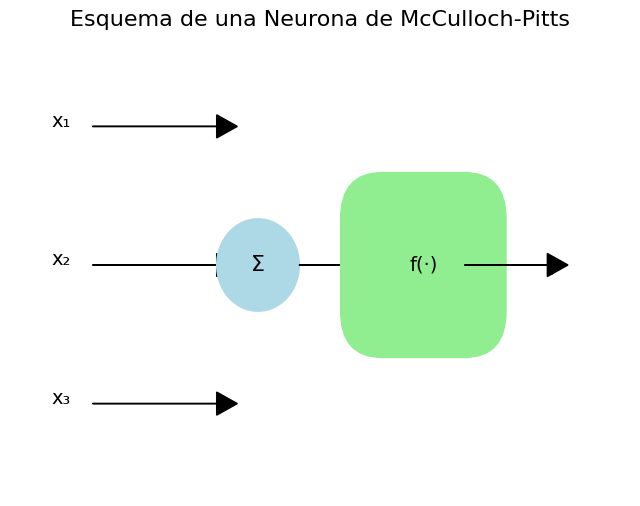

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Crear diagrama de una neurona de McCulloch-Pitts
fig, ax = plt.subplots(figsize=(8, 6))

# Entradas
inputs = ["x₁", "x₂", "x₃"]
for i, label in enumerate(inputs):
    ax.annotate(label, xy=(0.1, 0.8 - i*0.3), fontsize=14)
    ax.arrow(0.2, 0.8 - i*0.3, 0.3, 0, head_width=0.05, head_length=0.05, fc='black', ec='black')

# Suma ponderada
circle = patches.Circle((0.6, 0.5), 0.1, fill=True, color="lightblue", label="Suma")
ax.add_patch(circle)
ax.text(0.6, 0.5, "Σ", fontsize=16, ha="center", va="center")

# Activación
ax.arrow(0.7, 0.5, 0.2, 0, head_width=0.05, head_length=0.05, fc='black', ec='black')
rect = patches.FancyBboxPatch((0.9, 0.4), 0.2, 0.2, boxstyle="round,pad=0.1", color="lightgreen")
ax.add_patch(rect)
ax.text(1.0, 0.5, "f(·)", fontsize=14, ha="center", va="center")

# Salida
ax.arrow(1.1, 0.5, 0.2, 0, head_width=0.05, head_length=0.05, fc='black', ec='black')
ax.text(1.3, 0.5, "y", fontsize=14, va="center")

# Ajustes finales
ax.set_xlim(0, 1.5)
ax.set_ylim(0, 1)
ax.axis("off")
plt.title("Esquema de una Neurona de McCulloch-Pitts", fontsize=16)
plt.show()